In [772]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import harmonypy as hm
from matplotlib.cm import ScalarMappable
from datetime import date
import mpld3
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import panel as pn
import bokeh
from bokeh.resources import INLINE

import dimorph_processing as dp

today = str(date.today())
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
status_df = dp.intialize_status_df()

# This notebook compares the amygdala data from Hochgerner et al.  (https://www.nature.com/articles/s41593-023-01469-3) to the sexual dimorphism data analyzed in both "dimorph_processing_nb.ipynb" (level1) and "dimorph_cell_analysis_nb.ipynb" (level2)

### Load data from Hochgerner et al.

In [ ]:
amy_df = pd.read_csv('/bigdata/isaac/amy_fc_data/Amy_FC_allcells_with_metadata_31-Jul-2022.txt', encoding='utf-8', delimiter='\t') 

In [118]:
amy_df.head()

,cellID,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,...,TCGAACAAGGAGCTGT-1_76-1,TGTACAGTCTGCAGCG-1_76-1,AGGACTTTCATGGAGG-1_76-2,CCCATTGGTACCTAGT-1_76-2,CTATCTACAATTGCTG-1_76-2,CTCATCGTCACCCATC-1_76-2,CTGCCATGTATCGCTA-1_76-2,GCATGATTCTCGTCGT-1_76-2,TGGGCGTAGAAGCCAC-1_76-2,TTCTGTAGTGGTATGG-1_76-2
0,celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm
1,sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,...,76-1,76-1,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
2,FC time,2,2,2,2,2,2,2,2,0,...,2,2,2,2,2,2,2,2,2,2
3,batch,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
4,Xkr4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
type(amy_df.columns[1])

str

In [18]:
np.array(amy_df.iloc[:,1:2])

array([['GABA-11-Adora2a-Id4'],
       ['10-1'],
       ['2'],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [19]:
#save as feather for faster loading
#folder = '/bigdata/isaac/amy_fc_data/'
#amy_df = amy_df.astype(str)
#amy_df.to_feather(folder + 'amy_df.feather')

In [23]:
amy_df.columns

Index(['cellID', 'GGGTATTTCTCGCGTT-1_10-1', 'GGTAACTAGACATCCT-1_18-1',
       'GGTAATCGTGGACTAG-1_18-1', 'TTCCGGTAGTGGTGGT-1_18-1',
       'AGGGTGAAGTACAACA-1_19-1', 'AGTACCATCCCTGGTT-1_19-1',
       'CATGAGTTCCGGCTTT-1_19-1', 'TTGCCTGAGACGGTTG-1_19-1',
       'AAACGCTTCACCATGA-1_23-1',
       ...
       'TCGAACAAGGAGCTGT-1_76-1', 'TGTACAGTCTGCAGCG-1_76-1',
       'AGGACTTTCATGGAGG-1_76-2', 'CCCATTGGTACCTAGT-1_76-2',
       'CTATCTACAATTGCTG-1_76-2', 'CTCATCGTCACCCATC-1_76-2',
       'CTGCCATGTATCGCTA-1_76-2', 'GCATGATTCTCGTCGT-1_76-2',
       'TGGGCGTAGAAGCCAC-1_76-2', 'TTCTGTAGTGGTATGG-1_76-2'],
      dtype='object', length=55515)

In [120]:
amy_df = amy_df.set_index('cellID')

In [121]:
amy_df

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,TCGAACAAGGAGCTGT-1_76-1,TGTACAGTCTGCAGCG-1_76-1,AGGACTTTCATGGAGG-1_76-2,CCCATTGGTACCTAGT-1_76-2,CTATCTACAATTGCTG-1_76-2,CTCATCGTCACCCATC-1_76-2,CTGCCATGTATCGCTA-1_76-2,GCATGATTCTCGTCGT-1_76-2,TGGGCGTAGAAGCCAC-1_76-2,TTCTGTAGTGGTATGG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-1,76-1,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PISD,9,0,0,3,8,0,0,4,4,0,...,17,0,0,9,0,0,8,10,9,8
DHRSX,0,0,0,0,0,0,0,4,0,0,...,0,0,6,0,6,0,0,0,4,8


In [427]:
amy_df.shape

(28002, 55514)

In [122]:
np.unique(np.array(amy_df.loc['celltype']))

array(['Astro', 'Astro_SC', 'Astro_agt', 'COP', 'EC', 'Epend',
       'GABA-1-Foxp2_Fmod', 'GABA-10-Prkcd-Adora2a',
       'GABA-11-Adora2a-Id4', 'GABA-12-Adora2a-Scn4b',
       'GABA-13-Adora2a-Crh', 'GABA-14-Drd1-Scn4b', 'GABA-15-Drd1-Ebf1',
       'GABA-16-Prkcd-Nts', 'GABA-17-Pdyn-Ebf1', 'GABA-18-Isl1-Tac1',
       'GABA-19-Isl1-Aldoc', 'GABA-2-Foxp2_Adra2a',
       'GABA-20-Gpr101-Gabre', 'GABA-21-Vdr-Nts', 'GABA-22-Gal-Avp',
       'GABA-23-Fign-Lrpprc', 'GABA-24-Fign-Ucn3', 'GABA-25-Lhx8-Th',
       'GABA-26-Cbln4-Sst', 'GABA-27-Lhx6-Nxph2', 'GABA-28-Cbln4-Luzp2',
       'GABA-29-Prlr-Greb1', 'GABA-3-Foxp2_Col6a1', 'GABA-30-Prlr-Calcr',
       'GABA-31-Prlr-Cbln1', 'GABA-32-Prlr-Tac1', 'GABA-33-Prlr-St18',
       'GABA-34-Prlr-Satb1', 'GABA-35-Chodl-Moxd1', 'GABA-36-Sst-Fign',
       'GABA-37-Sst-Npy', 'GABA-38-Sst-Tmtc4', 'GABA-39-Sst-Nek7',
       'GABA-4-Foxp2_Htr1f', 'GABA-40-Rpb4-Sst', 'GABA-41-Moxd1-Pvalb',
       'GABA-42-Moxd1-Vwc2', 'GABA-43-Crabp1-Etv1', 'GABA-44-Pthlh

### seperate out metadata

In [293]:
amy_metadata_df = amy_df.iloc[:4,:]

### add "cell_class" row to metadata

In [294]:
cls = [x.split('-')[0] for x in np.array(amy_metadata_df.loc['celltype'])]

In [295]:
np.unique(cls)

array(['Astro', 'Astro_SC', 'Astro_agt', 'COP', 'EC', 'Epend', 'GABA',
       'OL', 'OPC', 'OPC_cycling', 'Peri', 'VGLUT1', 'VGLUT2', 'VLMC',
       'VSM', 'microglia', 'pvm'], dtype='<U11')

In [296]:
amy_metadata_df.loc['cell_class'] = cls

/tmp/ipykernel_2941225/1827095788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amy_metadata_df.loc['cell_class'] = cls


In [297]:
markers[0][0]

'Adora2a'

In [290]:
re.split(r"-|_",markers[0][0])[2:4]

['Adora2a', 'Id4']

In [298]:
markers = [re.split(r"-|_",x)[2:4] for x in np.array(amy_metadata_df.loc['celltype'])]
markers

[['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 

In [299]:
amy_metadata_df.loc['markers'] = markers

/tmp/ipykernel_2941225/4262783576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amy_metadata_df.loc['markers'] = markers


In [300]:
amy_metadata_df

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,TCGAACAAGGAGCTGT-1_76-1,TGTACAGTCTGCAGCG-1_76-1,AGGACTTTCATGGAGG-1_76-2,CCCATTGGTACCTAGT-1_76-2,CTATCTACAATTGCTG-1_76-2,CTCATCGTCACCCATC-1_76-2,CTGCCATGTATCGCTA-1_76-2,GCATGATTCTCGTCGT-1_76-2,TGGGCGTAGAAGCCAC-1_76-2,TTCTGTAGTGGTATGG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-1,76-1,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
cell_class,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,...,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm
markers,"[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]",...,[],[],[],[],[],[],[],[],[],[]


### cell classes of interest: GABA, Vglut1, Vglut2, NN = microglia + epend + astro

In [286]:
amy_df.head()

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,TCGAACAAGGAGCTGT-1_76-1,TGTACAGTCTGCAGCG-1_76-1,AGGACTTTCATGGAGG-1_76-2,CCCATTGGTACCTAGT-1_76-2,CTATCTACAATTGCTG-1_76-2,CTCATCGTCACCCATC-1_76-2,CTGCCATGTATCGCTA-1_76-2,GCATGATTCTCGTCGT-1_76-2,TGGGCGTAGAAGCCAC-1_76-2,TTCTGTAGTGGTATGG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-1,76-1,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
amy_df.loc['celltype'].index

Index(['GGGTATTTCTCGCGTT-1_10-1', 'GGTAACTAGACATCCT-1_18-1',
       'GGTAATCGTGGACTAG-1_18-1', 'TTCCGGTAGTGGTGGT-1_18-1',
       'AGGGTGAAGTACAACA-1_19-1', 'AGTACCATCCCTGGTT-1_19-1',
       'CATGAGTTCCGGCTTT-1_19-1', 'TTGCCTGAGACGGTTG-1_19-1',
       'AAACGCTTCACCATGA-1_23-1', 'TACCCACCAGTGACCC-1_23-1',
       ...
       'TCGAACAAGGAGCTGT-1_76-1', 'TGTACAGTCTGCAGCG-1_76-1',
       'AGGACTTTCATGGAGG-1_76-2', 'CCCATTGGTACCTAGT-1_76-2',
       'CTATCTACAATTGCTG-1_76-2', 'CTCATCGTCACCCATC-1_76-2',
       'CTGCCATGTATCGCTA-1_76-2', 'GCATGATTCTCGTCGT-1_76-2',
       'TGGGCGTAGAAGCCAC-1_76-2', 'TTCTGTAGTGGTATGG-1_76-2'],
      dtype='object', length=55514)

### isolate gaba columns

In [149]:
gaba_cols = [c for c,x in zip(amy_df.loc['celltype'].index,np.array(amy_df.loc['celltype'])) if 'GABA' in x]

In [330]:
amy_df_gaba = amy_df.loc[:,gaba_cols]

In [406]:
amy_df_gaba_expr = amy_df_gaba.iloc[4:,:]

In [407]:
amy_df_gaba_expr

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,0,0,0,...,7,0,6,0,0,0,2,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PISD,9,0,0,3,8,0,0,4,4,0,...,0,0,0,0,0,3,0,2,2,0
DHRSX,0,0,0,0,0,0,0,4,0,0,...,0,3,0,0,0,0,0,0,0,0


In [333]:
amy_metadata_df_gaba = amy_metadata_df.loc[:,gaba_cols]

### add "cluster_label" row to metadata

In [334]:
amy_gaba_cluster_labels = np.array(amy_metadata_df_gaba.loc['celltype'].apply(lambda x: int(re.search(r'-(\d+)-', x).group(1))))

In [335]:
np.unique(amy_gaba_cluster_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])

In [336]:
amy_metadata_df_gaba.loc['cluster_label'] = amy_gaba_cluster_labels

In [337]:
amy_metadata_df_gaba

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
cell_class,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,...,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA
markers,"[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]",...,"[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]"
cluster_label,11,11,11,11,11,11,11,11,11,11,...,51,51,51,51,51,51,51,51,51,51


In [408]:
amy_df_gaba_expr.shape

(27998, 13006)

In [409]:
amy_df_gaba_expr.head()

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,0,0,0,...,7,0,6,0,0,0,2,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [416]:
amy_df_gaba_expr[amy_df_gaba_expr.index.duplicated()][8:14]

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
Flg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Flg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Flg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Flg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Flg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Flg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [418]:
print ('# duplicate gene rows: ', amy_df_gaba_expr[amy_df_gaba_expr.index.duplicated()].shape[0])

# duplicate gene rows:  65


### Remove duplicate gene rows, keeping first instance

In [419]:
amy_df_gaba_expr = amy_df_gaba_expr[~amy_df_gaba_expr.index.duplicated(keep='first')]

In [420]:
amy_df_gaba_expr.shape

(27933, 13006)

### remove IEG genes

In [421]:
IEG_list = []

with open('/bigdata/isaac/IEG_cluster.txt', 'r') as fh:
    for g in fh:
        IEG_list.append(g[:-1])

In [422]:
amy_df_gaba_expr = dp.gene_remover(IEG_list, amy_df_gaba_expr)

removing  53  genes found in  ['Btg2', 'Jun', 'Egr4', 'Fosb', 'Junb', 'Gadd45g', 'Fos', 'Arc', 'Nr4a1', 'Npas4', 'Coq10b', 'Tns1', 'Per2', 'Ptgs2', 'Rnd3', 'Tnfaip6', 'Srxn1', 'Tiparp', 'Ccnl1', 'Mcl1', 'Dnajb5', 'Nr4a3', 'Fosl2', 'Nptx2', 'Rasl11a', 'Mest', 'Sertad1', 'Egr2', 'Midn', 'Gadd45b', 'Dusp6', 'Irs2', 'Plat', 'Ier2', 'Rrad', 'Tpbg', 'Csrnp1', 'Peli1', 'Per1', 'Kdm6b', 'Inhba', 'Plk2', 'Ifrd1', 'Baz1a', 'Trib1', 'Pim3', 'Lrrk2', 'Dusp1', 'Cdkn1a', 'Pim1', 'Sik1', 'Frat2', 'Dusp5']


In [423]:
amy_df_gaba_expr.shape

(27880, 13006)

In [424]:
#ensure all values are integers
amy_df_gaba_expr = amy_df_gaba_expr.astype('int')

### Perform gene exclusion + feature selection to get high variable genes of interest for amy data

In [346]:
amy_df_gaba_bool = amy_df_gaba_expr.mask(amy_df_gaba_expr>0, other = 1)

In [347]:
amy_df_gaba_expr

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,0,0,0,...,7,0,6,0,0,0,2,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sox17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PISD,9,0,0,3,8,0,0,4,4,0,...,0,0,0,0,0,3,0,2,2,0
DHRSX,0,0,0,0,0,0,0,4,0,0,...,0,3,0,0,0,0,0,0,0,0


In [348]:
amy_df_gaba_expr_ge, amy_df_gaba_bool, amy_metadata_df_gaba, status_df = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=amy_df_gaba_bool,
                                                     df = amy_df_gaba_expr,
                                                     meta_data_df = amy_metadata_df_gaba,
                                                     status_df = status_df)

Total genes reduced from 27880 to 14303


In [349]:
amy_df_gaba_expr_ge.shape

(14303, 13006)

<IPython.core.display.Javascript object>


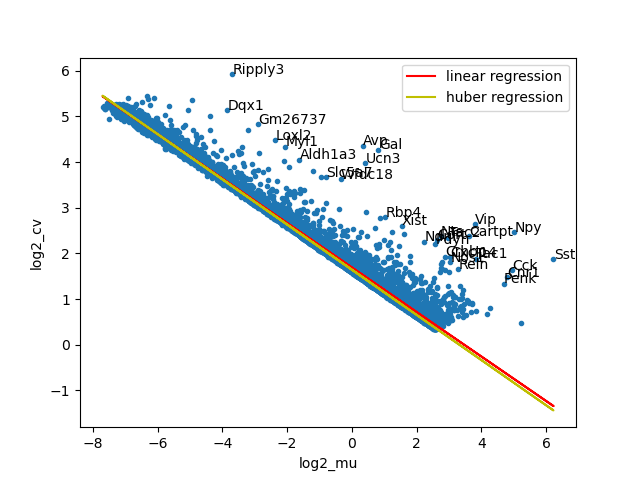

In [350]:
amy_gaba_cv_df = dp.analyze_cv(df = amy_df_gaba_expr_ge,
                      norm_scale_factor=20000,
                      num_top_genes=30,
                      plot_flag=1,
                     use_huber = True)

<IPython.core.display.Javascript object>


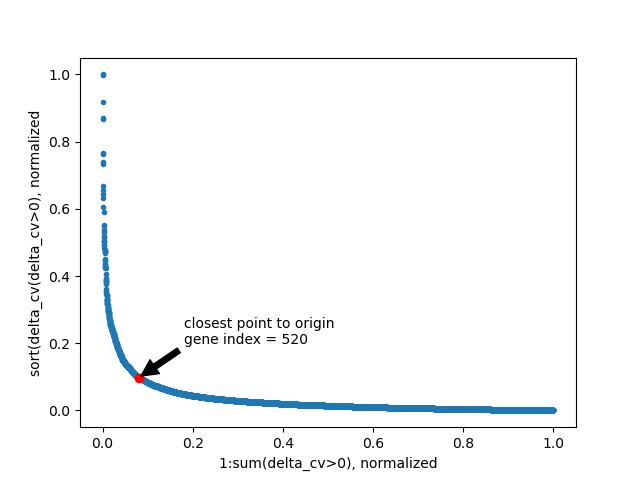

In [351]:
amy_gaba_gene_index, amy_df_gaba_expr_ge_cv, status_df = dp.get_top_cv_genes(df = amy_df_gaba_expr_ge, cv_df=amy_gaba_cv_df, plot_flag=1, status_df=status_df)

### log and standerdize amy_df_gaba_expr to match gaba_df_prelinkage_ls

In [354]:
amy_arr_gaba_expr_ge_cv_ls,status_df = dp.log_and_standerdize_df(amy_df_gaba_expr_ge_cv,status_df)

column (gene) mean after standardization: -0.00
column (gene) sigma after standardization: 1.00


In [355]:
#put outputted log/standerdized array back into dataframe format
amy_df_gaba_expr_ge_cv_ls = pd.DataFrame(data=amy_arr_gaba_expr_ge_cv_ls.T, index=amy_df_gaba_expr_ge_cv.index, columns=amy_df_gaba_expr_ge_cv.columns)

In [356]:
amy_df_gaba_expr_ge_cv_ls.shape

(520, 13006)

In [357]:
amy_df_gaba_expr_ge_cv_ls.head()

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
Sst,-0.545385,0.306249,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,1.157884,-0.545385,0.443332,...,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385
Npy,1.105514,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,...,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248
Gal,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,...,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651
Avp,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,...,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845
Vip,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,...,4.745730,5.499811,5.231021,4.307494,5.422867,4.210936,5.386956,5.816290,5.602638,5.026132


In [358]:
#save to file

#folder = '/bigdata/isaac/gaba_files/'

#file1 = 'amy_df_gaba_expr_ge_cv_ls_orig' 
#file2 = 'amy_metadata_df_gaba_orig' 

#amy_df_gaba_expr_ge_cv_ls.to_feather(folder+file1+'.feather')
#amy_metadata_df_gaba.to_json(folder+file2+'.json')

In [359]:
amy_df_gaba_expr_ge_cv_ls_orig = pd.read_feather(folder + 'amy_df_gaba_expr_ge_cv_ls_orig.feather')
amy_metadata_df_gaba_orig = pd.read_json(folder + 'amy_metadata_df_gaba_orig.json')

### Load gaba_df_prelinkage_ls saved from "dimorph_cell_analysis_nb.ipynb"
### already has feature selected genes

In [1090]:
#gaba_df_marker = pd.read_feather('/bigdata/isaac/gaba_files/gaba_df_marker_2024-06-07.feather')
gaba_meta_data_df_plis = pd.read_json('/bigdata/isaac/gaba_files/gaba_meta_data_df_plis2024-06-07.json')

gaba_df_prelinkage_ls_orig = pd.read_feather('/bigdata/isaac/gaba_files/gaba_df_pre_linkage_ls_2024-06-04.feather')
gaba_metadata_df_prelinkage_ls_orig = pd.read_json('/bigdata/isaac/gaba_files/gaba_meta_data_df_pre_linkage_2024-06-04.json')


In [363]:
lco = pd.unique(gaba_meta_data_df_plis.loc['cluster_label'])
lco

array([31, 12, 42, 43, 40, 39, 36, 55, 65, 33, 16, 38, 2, 20, 35, 0, 14,
       4, 5, 3, 15, 11, 10, 6, 21, 41, 37, 25, 18, 26, 22, 27, 24, 28, 8,
       7, 19, 17, 44, 46, 45, 9, 47, 50, 23, 1, 13, 29, 30, 32, 56, 51,
       57, 53, 48, 49, 59, 58, 61, 60, 63, 62, 54, 34, 64, 52],
      dtype=object)

In [1091]:
pd.unique(gaba_metadata_df_prelinkage_ls_orig.loc['cluster_label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], dtype=object)

In [365]:
gaba_df_prelinkage_ls_orig = gaba_df_prelinkage_ls_orig.T

In [366]:
gaba_df_prelinkage_ls_orig.shape

(559, 13529)

In [367]:
gaba_df_prelinkage_ls_orig.head()

,CCGGGTAGTGTTGAGG-1_10X51_3,TCTAACTAGTGGCCTC-1_10X36_1,CTATCCGGTAAGGTCG-1_10X51_2,AGCGATTGTGTCTAAC-1_10X52_1,TCGGATAGTAGGAAAG-1_10X37_1,TTACGTTGTATCAAGA-1_10X37_2,GGGCGTTAGCGTATAA-1_10X51_1,TAGACCACAGTCCGTG-1_10X51_1,CTACTATAGCCTGAGA-1_10X38_1,TCACGGGGTATCACGT-1_10X38_1,...,TTGAGTGTCAGTGCGC-1_10X36_1,CGCAGGTCATCGATGT-1_10X37_1,ATCGTAGAGAAGCTCG-1_10X52_2,GCAGCTGGTGTGTCCG-1_10X52_3,CATACCCCAGTTTCGA-1_10X52_1,ACCCAAAAGCATTGAA-1_10X38_1,CAGCGTGAGCCACAAG-1_10X51_2,AATTCCTGTGAATTAG-1_10X51_1,GACCTTCGTATGAGGC-1_10X38_1,GTCTTTACAGGTCCGT-1_10X37_1
gene,,,,,,,,,,,,,,,,,,,,,
Avp,-0.201913,-0.201913,2.945428,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,...,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913
Vip,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,...,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338
Sst,-0.395937,-0.395937,1.929167,1.804529,2.318293,-0.395937,1.929167,2.774148,-0.395937,-0.395937,...,1.663226,1.929167,1.929167,2.318293,2.233592,2.825778,2.396714,2.040659,1.929167,-0.395937
Cartpt,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,...,0.178540,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214
Ucn3,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,1.443596,-0.158813,...,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813


In [368]:
meta_data_df_prelinkage_ls.tail()

,CCGGGTAGTGTTGAGG-1_10X51_3,TCTAACTAGTGGCCTC-1_10X36_1,CTATCCGGTAAGGTCG-1_10X51_2,AGCGATTGTGTCTAAC-1_10X52_1,TCGGATAGTAGGAAAG-1_10X37_1,TTACGTTGTATCAAGA-1_10X37_2,GGGCGTTAGCGTATAA-1_10X51_1,TAGACCACAGTCCGTG-1_10X51_1,CTACTATAGCCTGAGA-1_10X38_1,TCACGGGGTATCACGT-1_10X38_1,...,TTGAGTGTCAGTGCGC-1_10X36_1,CGCAGGTCATCGATGT-1_10X37_1,ATCGTAGAGAAGCTCG-1_10X52_2,GCAGCTGGTGTGTCCG-1_10X52_3,CATACCCCAGTTTCGA-1_10X52_1,ACCCAAAAGCATTGAA-1_10X38_1,CAGCGTGAGCCACAAG-1_10X51_2,AATTCCTGTGAATTAG-1_10X51_1,GACCTTCGTATGAGGC-1_10X38_1,GTCTTTACAGGTCCGT-1_10X37_1
ngperul_seqlib,22.0,11.4,22.2,15.7,15.9,16.0,19.2,19.2,15.0,15.0,...,11.4,15.9,17.5,20.4(second prep),15.7,15.0,22.2,19.2,15.0,15.9
lengthbp_seqlib,487.0,476.0,474.0,466.0,440.0,460.0,478.0,478.0,420.0,420.0,...,476.0,440.0,440.0,507.0,466.0,420.0,474.0,478.0,420.0,440.0
Sample_Index,B2,H8,A2,D12,E9,F9,G1,G1,B9,B9,...,H8,E9,E12,F12,D12,B9,A2,G1,B9,E9
cell_class,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,...,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA
cluster_label,0,0,0,0,0,0,0,0,0,0,...,65,65,65,65,65,65,65,65,65,65


### Get Gene index shared by both datasets, then isolate only these genes from each

In [369]:
amy_df_gaba_expr_ge_cv_ls_orig.index

Index(['Sst', 'Npy', 'Gal', 'Avp', 'Vip', 'Ucn3', 'Cartpt', 'Ripply3', 'Cck',
       'Cnr1',
       ...
       'Pdzrn4', 'Krt12', 'Ppargc1a', 'Sowaha', 'Gm26822', 'Mdfic', 'Pld5',
       'Kcnip4', 'Tppp3', 'Lhfp'],
      dtype='object', name='cellID', length=520)

In [370]:
gaba_df_prelinkage_ls_orig.index

Index(['Avp', 'Vip', 'Sst', 'Cartpt', 'Ucn3', 'Nts', 'Gal', 'Cck', 'Npy',
       'Cort',
       ...
       'Tox', 'Pgr15l', 'Pex5l', 'Sema6d', 'Igsf1', 'Glra2', 'Dpy19l1',
       'Anxa2', 'Rnase4', 'Etv4'],
      dtype='object', name='gene', length=559)

In [371]:
#change to union?
intersected_gene_ind = amy_df_gaba_expr_ge_cv_ls_orig.index.intersection(gaba_df_prelinkage_ls_orig.index)
intersected_gene_ind

Index(['Sst', 'Npy', 'Gal', 'Avp', 'Vip', 'Ucn3', 'Cartpt', 'Ripply3', 'Cck',
       'Cnr1',
       ...
       'Nbl1', 'Jsrp1', 'Sostdc1', 'Shisa6', 'Fam19a2', 'Pdlim5', 'Ppargc1a',
       'Pld5', 'Kcnip4', 'Lhfp'],
      dtype='object', length=378)

In [372]:
amy_df_gaba_expr_ge_cv = amy_df_gaba_expr_ge_cv_ls_orig.reindex(index = intersected_gene_ind)
gaba_df_prelinkage_ls = gaba_df_prelinkage_ls_orig.reindex(index = intersected_gene_ind)

In [373]:
amy_df_gaba_expr_ge_cv.shape

(378, 13006)

In [374]:
gaba_df_prelinkage_ls.shape

(378, 13529)

### Checkpoint - save intersected data/metadata to file / load from here

In [210]:
folder

'/bigdata/isaac/gaba_files/'

In [311]:
#save to file

#folder = '/bigdata/isaac/gaba_files/'

#file1 = 'amy_df_gaba_expr_ge_cv_ls_cell_comp' 
#file2 = 'amy_metadata_df_gaba_cell_comp' 

#amy_df_gaba_expr_ge_cv_ls.to_feather(folder+file1+'.feather')
#amy_metadata_df_gaba.to_json(folder+file2+'.json')

#################################

#file1 = 'gaba_df_prelinkage_ls_cell_comp' 
#file2 = 'gaba_meta_data_df_prelinkage_cell_comp' 

#gaba_df_prelinkage_ls.to_feather(folder+file1+'.feather')
#gaba_meta_data_df_pre_linkage.to_json(folder+file2+'.json')


In [212]:
#load data
folder = '/bigdata/isaac/gaba_files/'

amy_df_gaba_expr_ge_cv_ls = pd.read_feather(folder + 'amy_df_gaba_expr_ge_cv_ls_cell_comp.feather')
amy_metadata_df_gaba = pd.read_json(folder + 'amy_metadata_df_gaba_cell_comp.json')

gaba_df_prelinkage_ls = pd.read_feather(folder + 'gaba_df_prelinkage_ls_cell_comp.feather')
gaba_meta_data_df_prelinkage = pd.read_json(folder + 'gaba_meta_data_df_prelinkage_cell_comp.json' )

### Compute avg expression for all genes, for every cluster

In [213]:
amy_avgs = dp.compute_avg_expr_per_cluster_label(amy_df_gaba_expr_ge_cv_ls,amy_metadata_df_gaba)

In [214]:
amy_avgs

,1,2,3,4,5,6,7,8,9,10,...,47,48,49,50,51,52,53,54,55,56
Sst,-0.155349,-0.280595,-0.455989,-0.492804,-0.148882,-0.314029,0.423542,-0.263417,-0.395131,-0.501013,...,0.155029,-0.447587,-0.450272,-0.514228,-0.427441,-0.440583,-0.451893,-0.427688,-0.345629,-0.444237
Npy,-0.359158,-0.22505,0.068509,0.900939,-0.086038,-0.150077,-0.38883,-0.387799,-0.364963,-0.282428,...,-0.333043,-0.372397,-0.366435,-0.401907,-0.352834,-0.374402,-0.396366,-0.403158,-0.264757,-0.154209
Gal,-0.112651,-0.112651,-0.089581,-0.112651,-0.074812,-0.069099,-0.112651,-0.087391,-0.068467,-0.112651,...,-0.097408,-0.105911,-0.050846,0.248763,-0.100601,-0.041433,-0.112651,-0.112651,-0.112651,-0.0807
Avp,-0.108845,-0.071297,-0.028345,-0.108845,-0.052378,-0.021984,-0.073287,-0.055146,-0.05929,-0.052248,...,-0.086099,-0.053048,0.014219,0.012632,0.005873,-0.026616,-0.08045,-0.026667,-0.108845,-0.067684
Vip,-0.211028,-0.20211,-0.196752,-0.158658,-0.172872,-0.205202,-0.204007,-0.19946,-0.199775,-0.193786,...,-0.172384,-0.192407,-0.048683,2.22628,4.872482,-0.2227,-0.116881,0.244626,3.712796,-0.111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pdlim5,-0.213751,0.238679,-0.262204,-0.221797,-0.258688,-0.112715,-0.231641,-0.040965,0.636983,-0.275033,...,-0.089209,-0.245919,-0.256575,-0.021224,0.016749,-0.197397,-0.220275,-0.12304,-0.148883,0.892313
Ppargc1a,0.367969,-0.343563,-0.508327,-0.56609,-0.381029,-0.377084,-0.113144,-0.000711,0.085683,0.054693,...,0.26656,0.462964,0.207191,-0.251954,-0.049666,-0.366242,-0.364607,-0.226413,-0.300026,-0.28419
Pld5,0.36542,0.951358,-0.240701,-0.005046,0.487558,0.130078,0.07014,-0.385895,-0.406659,-0.206469,...,-0.077231,-0.328914,0.729462,0.605465,-0.204186,-0.336766,-0.136654,-0.280694,-0.142431,-0.358911
Kcnip4,0.535392,0.517315,0.247973,0.685572,0.714297,0.258686,-0.060652,-0.047448,0.049714,0.321894,...,-0.681736,0.666536,0.522226,-0.083875,0.150193,-0.050973,-0.617036,0.345685,0.713779,-0.487957


In [11]:
sd_avgs = dp.compute_avg_expr_per_cluster_label(gaba_df_prelinkage_ls,gaba_meta_data_df_prelinkage)

In [12]:
sd_avgs

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
Sst,-0.052799,-0.335815,-0.350333,-0.355693,-0.383913,-0.355985,-0.340964,-0.19556,-0.265766,-0.236357,...,-0.345609,-0.358898,-0.361009,-0.373029,0.168473,-0.35041,3.078125,-0.03385,3.957141,1.575562
Npy,-0.283375,-0.266134,-0.274041,-0.277158,-0.251861,-0.277019,-0.264008,-0.249343,-0.260414,-0.258252,...,-0.254232,-0.279362,-0.083082,0.189093,0.126427,-0.287002,3.211631,0.065238,3.251905,1.751706
Gal,-0.126186,-0.074353,0.206326,-0.121254,-0.126186,-0.126186,-0.115208,-0.086827,-0.126186,-0.037761,...,-0.126186,-0.126186,-0.126186,-0.126186,-0.105983,-0.126186,-0.091943,-0.126186,-0.126186,-0.126186
Avp,0.125462,-0.006238,-0.049596,0.012925,-0.072924,0.011349,0.023045,-0.097437,0.052388,0.03684,...,-0.093788,0.046217,-0.201913,-0.02162,-0.085422,-0.071679,-0.099653,-0.047967,-0.201913,0.04019
Vip,-0.140506,-0.154338,-0.154338,-0.141714,-0.154338,-0.146863,-0.148718,-0.143694,-0.148833,-0.150188,...,6.180234,0.292554,-0.128649,-0.138424,-0.143997,-0.154338,-0.148495,-0.154338,-0.154338,-0.154338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pdlim5,-0.11998,-0.189726,-0.149567,-0.18336,-0.089394,-0.17088,-0.161391,-0.155866,-0.056705,-0.147878,...,0.067439,0.64145,1.137411,2.250012,-0.150619,-0.161587,-0.160266,-0.145376,0.050282,-0.189726
Ppargc1a,0.235094,0.649442,-0.308002,0.18521,-0.250753,-0.095112,-0.21442,-0.241566,-0.379606,0.034571,...,-0.370182,-0.106719,-0.106876,-0.580984,1.162206,1.274981,0.27052,0.336414,0.719777,-0.197765
Pld5,-0.278213,-0.290832,-0.170091,-0.381998,0.077507,0.216949,0.506481,0.246273,0.035793,-0.234992,...,-0.230746,-0.386371,0.332568,0.861317,-0.348903,-0.39976,-0.222383,-0.267581,-0.313061,-0.352265
Kcnip4,0.348098,-0.235703,-0.318286,0.679367,-0.318462,0.103619,0.194134,0.035256,0.159885,0.24254,...,-0.105421,-0.326052,-0.788783,-0.521333,-0.664137,-0.800358,-0.669239,-0.630478,0.099243,-0.284288


In [956]:
sd_avgs.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65],
      dtype='object')

In [958]:
np.unique(np.array(gaba_meta_data_df_prelinkage.loc['cluster_label']))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], dtype=object)

### Compute pearson correlation coeffcient for every column between avg expr datasets

corr_matrix_manual = dim(sd_avgs x amy_avgs)

In [13]:
# Initialize an empty dataframe to hold the correlation coefficients
corr_matrix_manual = pd.DataFrame(index=sd_avgs.columns, columns=amy_avgs.columns)

# Compute the correlation coefficients
for col1 in sd_avgs.columns:
    for col2 in amy_avgs.columns:
        corr_matrix_manual.loc[col1, col2] = sd_avgs[col1].corr(amy_avgs[col2])

In [14]:
corr_matrix_manual.shape

(66, 56)

In [15]:
corr_matrix_manual

,1,2,3,4,5,6,7,8,9,10,...,47,48,49,50,51,52,53,54,55,56
0,-0.01201,0.020433,0.06362,-0.02082,0.000904,0.027228,0.034012,-0.06181,0.142248,0.164479,...,0.04024,0.159923,-0.092633,-0.031112,-0.052816,-0.112296,-0.084936,-0.113639,-0.106715,-0.086127
1,0.08766,-0.039294,-0.034626,-0.013889,-0.004004,-0.069779,0.044852,0.064597,-0.0973,-0.034907,...,0.047653,0.152267,0.005393,-0.017404,-0.110333,-0.10663,-0.077786,-0.035559,-0.04132,0.005037
2,0.084488,0.032233,0.093602,0.166215,0.187083,0.114193,0.165848,0.172464,0.054936,0.028032,...,-0.245826,-0.215955,-0.11534,-0.009132,-0.198511,-0.267668,-0.196831,-0.220429,-0.166209,-0.118693
3,0.175915,0.19637,0.155996,0.099051,0.128262,0.006573,0.079272,0.061207,0.151743,0.176193,...,-0.003676,0.629394,0.083292,-0.046276,-0.101233,-0.02545,-0.022972,-0.059853,-0.065599,-0.082605
4,0.051464,0.081996,0.149322,0.24157,0.41849,0.237807,0.35341,0.281377,0.224841,0.186672,...,-0.165283,0.03575,0.024819,-0.019976,-0.117015,-0.139005,-0.126627,-0.155594,-0.149778,-0.129659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,-0.104907,-0.137763,-0.173484,-0.163342,-0.263405,-0.211678,-0.229007,-0.167774,-0.131576,-0.111821,...,0.087417,-0.072357,-0.092484,-0.013462,0.050144,-0.028618,0.00802,0.012118,0.033511,0.04108
62,-0.101302,-0.171687,-0.226034,-0.195269,-0.288026,-0.229857,-0.188199,-0.187155,-0.162989,-0.174742,...,0.128739,-0.094751,-0.073041,-0.059805,0.006234,-0.014712,0.033338,-0.026364,-0.054414,-0.021657
63,-0.059025,-0.187182,-0.280098,-0.283435,-0.349985,-0.302309,-0.282447,-0.196692,-0.133033,-0.16159,...,0.095116,-0.058105,0.02356,-0.018006,0.086695,0.090782,0.01142,-0.000663,-0.017045,-0.025021
64,-0.054707,-0.126893,-0.159199,-0.112919,-0.173601,-0.170755,-0.109088,-0.101524,-0.132849,-0.13749,...,0.054623,-0.073408,0.016512,-0.063889,-0.094688,-0.053171,-0.042992,-0.081869,-0.065134,-0.043778


In [216]:
# Calculate the 2nd and 98th percentiles for robust scaling (mimicing seaborn's robust = TRUE)
#vmin, vmax = np.percentile(corr_matrix_manual.values, [2, 98])

# Create the heatmap
heatmap = corr_matrix_manual.hvplot.heatmap( cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap)
    
# Ensure output is displayed inline
hv.output(heatmap, backend='bokeh')

Launching server at http://localhost:37485


:HeatMap   [columns,index]   (value)

In [17]:
#take argmax of every row of corr_matrix_manual, store in seperate dataframe, then resort corr_matrix_manual rows by ascending arg_max values
heatmap_argmax_df = pd.DataFrame(columns = ['argmax','max'], index=corr_matrix_manual.index)
for i in corr_matrix_manual.index:
    heatmap_argmax_df.iloc[i,:] = (np.argmax(corr_matrix_manual.loc[i,:]),np.max(corr_matrix_manual.loc[i,:]))
heatmap_argmax_df.sort_values(by = 'argmax')
corr_matrix_manual_sorted = corr_matrix_manual.reindex(index = heatmap_argmax_df.sort_values(by = 'argmax').index)

In [18]:
corr_matrix_manual_sorted.index

Index([17, 19, 44,  4,  6, 25, 18,  8, 46, 22, 28, 26, 15, 14,  0, 24, 11,  7,
       10, 30, 45, 27, 32, 34, 23,  1, 35, 47, 29, 50, 13,  5, 20,  2, 38,  9,
       16, 39, 43, 12, 40, 42, 55, 65, 33, 36, 54, 64, 52, 62, 60, 63, 61, 58,
       59, 53,  3, 49, 48, 37, 41, 21, 31, 56, 51, 57],
      dtype='object')

In [19]:
corr_matrix_manual_sorted

,1,2,3,4,5,6,7,8,9,10,...,47,48,49,50,51,52,53,54,55,56
17,0.454419,0.832672,0.803021,0.748034,0.371633,0.192474,0.187261,0.080278,0.105659,0.17905,...,-0.163907,-0.114661,-0.113758,-0.077285,-0.193746,-0.200553,-0.142442,-0.22069,-0.172419,-0.162796
19,0.150352,0.167306,0.347238,0.241095,0.191112,0.201605,0.111167,0.102905,0.084646,0.141948,...,-0.192649,-0.118739,-0.019246,0.021432,-0.009899,-0.054148,-0.124346,-0.063262,-0.04084,-0.073694
44,0.129356,0.177138,0.384141,0.312789,0.27007,0.314081,0.122117,0.097171,0.099063,0.219512,...,-0.176532,-0.165148,-0.123377,0.017607,-0.113162,-0.139942,-0.144746,-0.173643,-0.119941,-0.095706
4,0.051464,0.081996,0.149322,0.24157,0.41849,0.237807,0.35341,0.281377,0.224841,0.186672,...,-0.165283,0.03575,0.024819,-0.019976,-0.117015,-0.139005,-0.126627,-0.155594,-0.149778,-0.129659
6,0.039921,0.135038,0.224698,0.279188,0.365738,0.263527,0.243114,0.146278,0.043015,0.104321,...,-0.153249,-0.073177,0.181785,-0.009951,-0.005331,-0.011447,-0.049938,0.012084,0.018422,-0.033226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,0.059859,0.109444,0.074455,0.112215,0.200794,0.094597,0.216131,0.10002,-0.099584,-0.06769,...,0.060636,0.206905,0.606596,0.029971,0.137644,0.196431,0.141816,0.172982,0.171186,0.103465
31,0.004663,-0.001427,-0.015587,-0.019255,0.010691,0.091802,0.02666,0.024942,0.001592,-0.014212,...,-0.046535,-0.029529,-0.024156,0.887527,-0.022797,-0.057957,-0.001193,-0.028446,-0.061469,0.00666
56,-0.130521,-0.164516,-0.170299,-0.204525,-0.200786,-0.255927,-0.215673,-0.112106,-0.093364,-0.102917,...,0.148411,-0.040106,0.177473,0.215484,0.937958,0.536146,0.393072,0.493056,0.658563,0.254165
51,-0.035846,-0.100492,-0.126225,-0.175526,-0.225366,-0.277157,-0.240271,-0.176025,-0.164085,-0.177361,...,0.372539,0.085133,0.175069,0.117657,0.530856,0.785322,0.926582,0.662005,0.44507,0.359548


In [217]:
#create tuple list of pos/ylabels to show updated index order on y axis
pos_ylabel = [(pos,ylabel) for pos,ylabel in zip(np.arange(len(corr_matrix_manual_sorted.index)),corr_matrix_manual_sorted.index)]

# Create the heatmap
# have reset the index to plot with updated order
heatmap2 = corr_matrix_manual_sorted.reset_index().drop(columns='index').hvplot.heatmap(title='Arg Max sorted Sd_avgs (y) correlated with Amy_avgs',
                                                        cmap='viridis', width=900, height=900, colorbar=True)

heatmap2.opts(xlabel='Cluster IDs (Amy_avgs)',ylabel='Cluster IDs (Sd_avgs)',yticks = pos_ylabel)

# Display the plot
hvplot.show(heatmap2)
    
# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

#save
#folder = '/bigdata/isaac/gaba_files/'
#panel_object = pn.pane.HoloViews(heatmap2)
#pn.pane.HoloViews(heatmap2).save(folder+'gaba_corr_plot_sd_amy', embed=True, resources=INLINE)

Launching server at http://localhost:41859


:HeatMap   [columns,index]   (value)

In [21]:
#flip axes - put amy_avgs on vertical

In [22]:
# Initialize an empty dataframe to hold the correlation coefficients
corr_matrix_manual_alt = pd.DataFrame(index=amy_avgs.columns, columns=sd_avgs.columns)

# Compute the correlation coefficients (note we could also have just taken transpose of corr_matrix_manual)
for col1 in amy_avgs.columns:
    for col2 in sd_avgs.columns:
        corr_matrix_manual_alt.loc[col1, col2] = amy_avgs[col1].corr(sd_avgs[col2])

In [23]:
#corr_matrix_manual.T.compare(corr_matrix_manual_alt)

In [ ]:
#pandas bug?

In [24]:
corr_matrix_manual.T.iloc[2:3,:1] == corr_matrix_manual_alt.iloc[2:3,:1]

,0
3,True


In [25]:
corr_matrix_manual.T.iloc[2:3,:1]

,0
3,0.06362


In [26]:
corr_matrix_manual_alt.iloc[2:3,:1]

,0
3,0.06362


In [27]:
corr_matrix_manual.T.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
1,-0.01201,0.08766,0.084488,0.175915,0.051464,0.159289,0.039921,-0.001414,0.113346,0.152873,...,-0.130521,-0.091128,-0.158778,-0.152925,-0.116517,-0.104907,-0.101302,-0.059025,-0.054707,-0.043558
2,0.020433,-0.039294,0.032233,0.19637,0.081996,0.1562,0.135038,0.05036,0.252681,0.080612,...,-0.164516,-0.163251,-0.11688,-0.08438,-0.218683,-0.137763,-0.171687,-0.187182,-0.126893,-0.105922
3,0.06362,-0.034626,0.093602,0.155996,0.149322,0.193274,0.224698,0.120819,0.336158,0.107055,...,-0.170299,-0.230491,-0.238772,-0.219743,-0.26012,-0.173484,-0.226034,-0.280098,-0.159199,-0.108965
4,-0.02082,-0.013889,0.166215,0.099051,0.24157,0.218484,0.279188,0.153875,0.42638,0.153371,...,-0.204525,-0.254378,-0.252921,-0.238519,-0.267836,-0.163342,-0.195269,-0.283435,-0.112919,-0.108461
5,0.000904,-0.004004,0.187083,0.128262,0.41849,0.319849,0.365738,0.346808,0.583184,0.237838,...,-0.200786,-0.269656,-0.327786,-0.292073,-0.356197,-0.263405,-0.288026,-0.349985,-0.173601,-0.175166


In [28]:
corr_matrix_manual_alt.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
1,-0.01201,0.08766,0.084488,0.175915,0.051464,0.159289,0.039921,-0.001414,0.113346,0.152873,...,-0.130521,-0.091128,-0.158778,-0.152925,-0.116517,-0.104907,-0.101302,-0.059025,-0.054707,-0.043558
2,0.020433,-0.039294,0.032233,0.19637,0.081996,0.1562,0.135038,0.05036,0.252681,0.080612,...,-0.164516,-0.163251,-0.11688,-0.08438,-0.218683,-0.137763,-0.171687,-0.187182,-0.126893,-0.105922
3,0.06362,-0.034626,0.093602,0.155996,0.149322,0.193274,0.224698,0.120819,0.336158,0.107055,...,-0.170299,-0.230491,-0.238772,-0.219743,-0.26012,-0.173484,-0.226034,-0.280098,-0.159199,-0.108965
4,-0.02082,-0.013889,0.166215,0.099051,0.24157,0.218484,0.279188,0.153875,0.42638,0.153371,...,-0.204525,-0.254378,-0.252921,-0.238519,-0.267836,-0.163342,-0.195269,-0.283435,-0.112919,-0.108461
5,0.000904,-0.004004,0.187083,0.128262,0.41849,0.319849,0.365738,0.346808,0.583184,0.237838,...,-0.200786,-0.269656,-0.327786,-0.292073,-0.356197,-0.263405,-0.288026,-0.349985,-0.173601,-0.175166


In [29]:
corr_matrix_manual.T.head() == corr_matrix_manual_alt.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
1,True,False,True,True,False,True,True,False,True,True,...,True,False,False,True,False,True,True,False,False,True
2,False,True,True,True,True,True,True,False,True,False,...,False,True,True,True,True,True,True,False,True,False
3,True,True,True,False,True,True,True,False,True,True,...,True,True,False,True,True,True,True,True,True,True
4,True,False,True,True,False,True,False,True,True,True,...,True,True,True,True,False,False,True,True,True,True
5,False,False,False,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,False,False


In [30]:
# Create the heatmap
heatmap = corr_matrix_manual_alt.hvplot.heatmap( cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap)
    
# Ensure output is displayed inline
hv.output(heatmap, backend='bokeh')

Launching server at http://localhost:41305


:HeatMap   [columns,index]   (value)

In [31]:
corr_matrix_manual.shape

(66, 56)

In [32]:
corr_matrix_manual_alt.index

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56],
      dtype='object')

In [34]:
heatmap_argmax_df_alt = pd.DataFrame(columns = ['argmax','max'], index=corr_matrix_manual_alt.index)
for i in corr_matrix_manual_alt.index:
    #print (i)
    heatmap_argmax_df_alt.loc[i,:] = (np.argmax(corr_matrix_manual_alt.loc[i,:]),np.max(corr_matrix_manual_alt.loc[i,:]))
heatmap_argmax_df_alt.sort_values(by = 'argmax')
corr_matrix_manual_alt_sorted = corr_matrix_manual_alt.reindex(index = heatmap_argmax_df_alt.sort_values(by = 'argmax').index)

In [35]:
corr_matrix_manual_alt_sorted.index

Index([21, 28, 23, 16,  5,  6,  7,  8,  9, 29, 30,  1,  3,  4,  2, 13, 12, 11,
       10, 27, 22, 18, 20, 19, 17, 15, 14, 50, 25, 33, 26, 34, 31, 49, 32, 24,
       48, 53, 52, 37, 47, 35, 51, 54, 56, 55, 45, 46, 41, 40, 39, 44, 38, 43,
       42, 36],
      dtype='object')

In [36]:
#create tuple list of pos/ylabels to show updated index order on y axis
pos_ylabel = [(pos,ylabel) for pos,ylabel in zip(np.arange(len(corr_matrix_manual_alt_sorted.index)),corr_matrix_manual_alt_sorted.index)]


heatmap2 = corr_matrix_manual_alt_sorted.reset_index().drop(columns='index').hvplot.heatmap(title='Arg Max sorted Amy_avgs (y) correlated with Sd_avgs',
                                                                                            cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap2)

heatmap2.opts(xlabel='Cluster IDs (Sd_avgs)',ylabel='Cluster IDs (Amy_avgs)',yticks = pos_ylabel)

# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

#save
#folder = '/bigdata/isaac/gaba_files/'
#panel_object = pn.pane.HoloViews(heatmap2)
#pn.pane.HoloViews(heatmap2).save(folder+'gaba_corr_plot_amy_sd', embed=True, resources=INLINE)

Launching server at http://localhost:39179


:HeatMap   [columns,index]   (value)

Repeat argmax sort of amy_avgs, but start with linkage clustered ordered (lco) version of sd_avgs

In [37]:
lco

array([31, 12, 42, 43, 40, 39, 36, 55, 65, 33, 16, 38, 2, 20, 35, 0, 14,
       4, 5, 3, 15, 11, 10, 6, 21, 41, 37, 25, 18, 26, 22, 27, 24, 28, 8,
       7, 19, 17, 44, 46, 45, 9, 47, 50, 23, 1, 13, 29, 30, 32, 56, 51,
       57, 53, 48, 49, 59, 58, 61, 60, 63, 62, 54, 34, 64, 52],
      dtype=object)

In [38]:
sd_avgs_lco = sd_avgs.reindex(columns=lco)
sd_avgs_lco

,31,12,42,43,40,39,36,55,65,33,...,59,58,61,60,63,62,54,34,64,52
Sst,-0.223437,-0.315668,-0.357998,-0.338641,-0.321785,-0.314075,0.122518,0.880006,1.575562,-0.116293,...,-0.373029,-0.361009,-0.35041,0.168473,-0.03385,3.078125,2.945473,2.450386,3.957141,3.768919
Npy,-0.132572,-0.283049,-0.264271,-0.266695,-0.186919,-0.228086,0.169287,0.908454,1.751706,0.011504,...,0.189093,-0.083082,-0.287002,0.126427,0.065238,3.211631,3.563586,-0.10661,3.251905,5.167316
Gal,1.480564,0.785527,-0.126186,0.038577,-0.126186,0.490776,0.703989,-0.126186,-0.126186,-0.044276,...,-0.126186,-0.126186,-0.126186,-0.105983,-0.126186,-0.091943,-0.117074,-0.074353,-0.126186,-0.040732
Avp,-0.201913,0.06041,0.123674,-0.033364,-0.060235,-0.035591,0.014414,-0.201913,0.04019,-0.083046,...,-0.02162,-0.201913,-0.071679,-0.085422,-0.047967,-0.099653,-0.015205,0.030267,-0.201913,0.13834
Vip,-0.154338,-0.140265,-0.154338,-0.144008,-0.144348,0.061426,-0.143829,0.036057,-0.154338,-0.122114,...,-0.138424,-0.128649,-0.154338,-0.143997,-0.154338,-0.148495,-0.14501,-0.141072,-0.154338,-0.110598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pdlim5,1.30081,0.09411,0.355809,-0.120277,0.051682,-0.123382,-0.030759,-0.189726,-0.189726,-0.169257,...,2.250012,1.137411,-0.161587,-0.150619,-0.145376,-0.160266,0.193419,-0.156282,0.050282,-0.079452
Ppargc1a,0.157807,0.162561,0.450427,0.182796,0.050666,-0.459735,0.378237,0.383763,-0.197765,0.139078,...,-0.580984,-0.106876,1.274981,1.162206,0.336414,0.27052,-0.023761,0.44754,0.719777,-0.105637
Pld5,2.932195,0.063337,0.431184,0.29747,-0.132108,0.932919,-0.072004,0.703668,-0.352265,0.65838,...,0.861317,0.332568,-0.39976,-0.348903,-0.267581,-0.222383,-0.400876,-0.378972,-0.313061,-0.062061
Kcnip4,0.820734,-0.62794,-0.507226,-0.262336,-0.382275,-0.225523,-0.215369,-0.158069,-0.284288,0.215449,...,-0.521333,-0.788783,-0.800358,-0.664137,-0.630478,-0.669239,-0.052005,1.300695,0.099243,-0.014176


In [39]:
# Initialize an empty dataframe to hold the correlation coefficients
corr_matrix_manual_alt_lco = pd.DataFrame(index=amy_avgs.columns, columns=sd_avgs_lco.columns)

# Compute the correlation coefficients (note we could also have just taken transpose of corr_matrix_manual)
for col1 in amy_avgs.columns:
    for col2 in sd_avgs_lco.columns:
        corr_matrix_manual_alt_lco.loc[col1, col2] = amy_avgs[col1].corr(sd_avgs_lco[col2])

In [40]:
# Create the heatmap
heatmap = corr_matrix_manual_alt_lco.hvplot.heatmap( cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap)
    
# Ensure output is displayed inline
hv.output(heatmap, backend='bokeh')

Launching server at http://localhost:42659


:HeatMap   [columns,index]   (value)

In [41]:
heatmap_argmax_df_alt_lco = pd.DataFrame(columns = ['argmax','max'], index=corr_matrix_manual_alt_lco.index)
for i in corr_matrix_manual_alt_lco.index:
    #print (i)
    heatmap_argmax_df_alt_lco.loc[i,:] = (np.argmax(corr_matrix_manual_alt_lco.loc[i,:]),np.max(corr_matrix_manual_alt_lco.loc[i,:]))
heatmap_argmax_df_alt_lco.sort_values(by = 'argmax')
corr_matrix_manual_alt_lco_sorted = corr_matrix_manual_alt_lco.reindex(index = heatmap_argmax_df_alt_lco.sort_values(by = 'argmax').index)

In [42]:
corr_matrix_manual_alt_lco_sorted.index

Index([50, 32, 31, 34, 33, 30, 21, 28, 49, 10, 11, 12, 13, 14, 15, 17, 19, 22,
       20, 18,  6,  5,  7,  8,  9, 16, 23,  1,  4,  2,  3, 24, 29, 27, 25, 51,
       53, 52, 54, 55, 56, 47, 48, 46, 45, 44, 40, 39, 41, 43, 42, 38, 35, 26,
       36, 37],
      dtype='object')

In [43]:
pos_ylabel = [(pos,ylabel) for pos,ylabel in zip(np.arange(len(corr_matrix_manual_alt_lco_sorted.index)),corr_matrix_manual_alt_lco_sorted.index)]
heatmap2 = corr_matrix_manual_alt_lco_sorted.reset_index().drop(columns='index').hvplot.heatmap(title='Arg Max sorted Amy_avgs (y) correlated with Sd_avgs_linkage_sorted (x)',  
                                                                                                yticks = corr_matrix_manual_alt_lco_sorted.index,
                                                                                                cmap='viridis', width=900, height=900, colorbar=True)
heatmap2.opts(xlabel='Cluster IDs (Sd_avgs)',ylabel='Cluster IDs (Amy_avgs)',yticks = pos_ylabel )

# Display the plot
hvplot.show(heatmap2)
    
# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

#save
#folder = '/bigdata/isaac/gaba_files/'
#panel_object = pn.pane.HoloViews(heatmap2)
#pn.pane.HoloViews(heatmap2).save(folder+'gaba_corr_plot_amy_sd_lco', embed=True, resources=INLINE)

Launching server at http://localhost:45037


:HeatMap   [columns,index]   (value)

In [44]:
#corr_matrix_manual_alt_lco_sorted

In [45]:
connector_df_alt_lco = heatmap_argmax_df_alt_lco.sort_values(by = 'argmax').copy()
connector_df_alt_lco.insert(2, 'corr_cluster', corr_matrix_manual_alt_lco.columns[np.array(connector_df_alt_lco['argmax']).astype('int')])

In [46]:
np.array(connector_df_alt_lco['argmax']).astype('int')

array([ 0,  3,  5,  6,  9, 10, 15, 18, 25, 28, 28, 28, 28, 29, 29, 29, 29,
       32, 32, 32, 34, 34, 34, 34, 34, 35, 35, 37, 37, 37, 37, 40, 41, 44,
       49, 50, 51, 51, 52, 52, 52, 53, 55, 56, 57, 58, 59, 59, 59, 60, 60,
       61, 62, 63, 64, 65])

In [47]:
corr_matrix_manual_alt_lco.columns[np.array(connector_df_alt_lco['argmax']).astype('int')]

Index([31, 43, 39, 36, 33, 16,  0,  5, 41, 18, 18, 18, 18, 26, 26, 26, 26, 24,
       24, 24,  8,  8,  8,  8,  8,  7,  7, 17, 17, 17, 17, 45,  9, 23, 32, 56,
       51, 51, 57, 57, 57, 53, 49, 59, 58, 61, 60, 60, 60, 63, 63, 62, 54, 34,
       64, 52],
      dtype='object')

In [48]:
connector_df_alt_lco = connector_df_alt_lco.reset_index()

In [49]:
connector_df_alt_lco

,index,argmax,max,corr_cluster
0,50,0,0.887527,31
1,32,3,0.873589,43
2,31,5,0.887938,39
3,34,6,0.893623,36
4,33,9,0.89231,33
5,30,10,0.888857,16
6,21,15,0.313583,0
7,28,18,0.719461,5
8,49,25,0.829003,41
9,10,28,0.344838,18


In [50]:
np.array(connector_df_alt_lco['index'])

array([50, 32, 31, 34, 33, 30, 21, 28, 49, 10, 11, 12, 13, 14, 15, 17, 19,
       22, 20, 18,  6,  5,  7,  8,  9, 16, 23,  1,  4,  2,  3, 24, 29, 27,
       25, 51, 53, 52, 54, 55, 56, 47, 48, 46, 45, 44, 40, 39, 41, 43, 42,
       38, 35, 26, 36, 37])

In [51]:
len(connector_df_alt_lco['index'])

56

In [52]:
np.zeros((1,len(connector_df_alt_lco['index'])))[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [53]:
amy_c_pts = [(x,y) for x,y in zip(np.zeros((1,len(connector_df_alt_lco['index'])))[0],np.array(connector_df_alt_lco['index']))]

In [54]:
sd_c_pts = [(x,y) for x,y in zip(np.ones((1,len(connector_df_alt_lco['corr_cluster'])))[0],np.array(connector_df_alt_lco['corr_cluster']))]

In [55]:
np.sort(np.array(connector_df_alt_lco['index']))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])

In [99]:
np.sort(np.array(connector_df_alt_lco['corr_cluster']))

array([0, 5, 7, 7, 8, 8, 8, 8, 8, 9, 16, 17, 17, 17, 17, 18, 18, 18, 18,
       23, 24, 24, 24, 26, 26, 26, 26, 31, 32, 33, 34, 36, 39, 41, 43, 45,
       49, 51, 51, 52, 53, 54, 56, 57, 57, 57, 58, 59, 60, 60, 60, 61, 62,
       63, 63, 64], dtype=object)

In [57]:
folder

'/bigdata/isaac/gaba_files/'

<IPython.core.display.Javascript object>


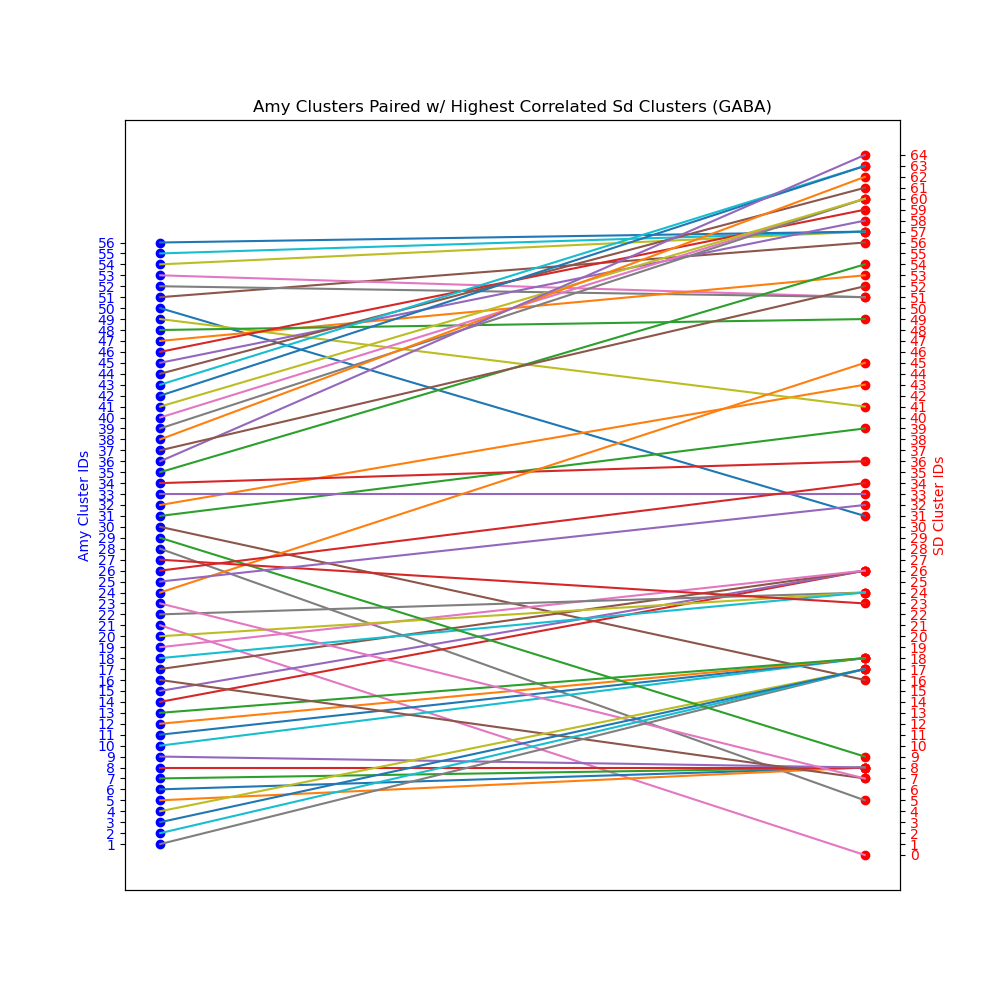

In [107]:
fig,ax1 = plt.subplots(figsize = (10,10))
ax1.set_title('Amy Clusters Paired w/ Highest Correlated Sd Clusters (GABA)')

ax2 = ax1.twinx()

x1 = np.zeros((1,len(connector_df_alt_lco['index'])))[0]
y1 = np.array(connector_df_alt_lco['index'])

x2 = np.ones((1,len(connector_df_alt_lco['corr_cluster'])))[0]
y2 = np.array(connector_df_alt_lco['corr_cluster'])

ax1.scatter(x = x1, 
            y = y1, color = 'b', label = 'amy_clusters')


ax1.set_yticks(np.sort(np.array(connector_df_alt_lco['index'])))
#plt.xticks([])
ax1.set_xticks([])
ax1.set_ylabel('Amy Cluster IDs', color = 'b')
ax1.tick_params(labelcolor = 'b')



ax1.scatter(x = x2, 
            y = y2, color = 'r', label = 'sd_clusters')

for i in range(len(connector_df_alt_lco)):
    plt.plot([x1[i], x2[i]], [y1[i], y2[i]], '-') 
    

#plt.ylabel('cluster_id')
#plt.yticks(np.arange(1,57))



ax2.set_yticks(np.arange(-1,np.max(np.array(connector_df_alt_lco['corr_cluster'])))+1)

ax2.set_ylabel('SD Cluster IDs', color = 'r')
ax2.tick_params(labelcolor = 'r')

#ax1.legend()
plt.savefig(folder+'gaba_connector_plot_amy_sd_lco_v2.png')
plt.show()

In [305]:
amy_metadata_df_gaba

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
cell_class,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,...,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA
markers,"[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]",...,"[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]"
cluster_label,11,11,11,11,11,11,11,11,11,11,...,51,51,51,51,51,51,51,51,51,51


In [220]:
pd.unique(amy_metadata_df_gaba.loc['cluster_label'])

array([11, 12, 30, 50, 43, 13, 7, 48, 18, 15, 14, 19, 55, 31, 34, 1, 22,
       25, 20, 42, 41, 45, 4, 54, 29, 46, 56, 27, 23, 28, 49, 8, 5, 6, 3,
       10, 9, 16, 52, 47, 53, 40, 2, 26, 39, 35, 36, 38, 37, 33, 32, 17,
       24, 44, 21, 51], dtype=object)

In [306]:
#get list of lists of markers, then list of unique marker list, preserving order
all_m = [amy_metadata_df_gaba.loc['markers'][x] for x in range((amy_metadata_df_gaba.loc['markers'].shape[0]))]

all_m_u = []
for x in all_m:
    if x not in all_m_u:
        all_m_u.append(x)

/tmp/ipykernel_2941225/1033362093.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_m = [amy_metadata_df_gaba.loc['markers'][x] for x in range((amy_metadata_df_gaba.loc['markers'].shape[0]))]


In [439]:
#sanity check of markers from meta data in index of expression matrix
error_genes = []
for x in all_m_u:
    for g in x:
        if g in amy_df_gaba_expr.index:
            pass
        else:
            print ('gene, ',g ,'not found in index')
            error_genes.append(g)

gene,  Hctr2 not found in index
gene,  Scng not found in index
gene,  Rpb4 not found in index


In [440]:
error_genes

['Hctr2', 'Scng', 'Rpb4']

There are 3 typos of marker genes in amy metadata stored in 'error genes' list above. The corrected gene names do appear in the index:

In [441]:
correct_gene_names = ['Hcrtr2','Sncg','Rbp4']

In [434]:
for g in correct_gene_names:
    if g in amy_df_gaba_expr.index:
        print ('found gene, ',g ,' in index')

found gene,  Hcrtr2  in index
found gene,  Sncg  in index
found gene,  Rbp4  in index


In [437]:
error_genes

['Hctr2', 'Scng', 'Rpb4']

Replace the misspelled genes in with correct ones in all_m_u

In [463]:
for eg,cg in zip(error_genes,correct_gene_names):
    for i,x in enumerate(all_m_u):
        for j,g in enumerate(x):
            if g == eg:
                #print (all_m_u[i][j])
                #if first and last letter of eg matches cg, replace with cg
                if cg[:1] == g[:1] and cg[-1:] == g[-1:]:
                    #print (cg)
                    #print (all_m_u[i][j])
                    all_m_u[i][j] = cg
                
                

                

In [464]:
all_m_u

[['Adora2a', 'Id4'],
 ['Adora2a', 'Scn4b'],
 ['Prlr', 'Calcr'],
 ['Chat', 'Vip'],
 ['Crabp1', 'Etv1'],
 ['Adora2a', 'Crh'],
 ['Pax6', 'Cyp26a1'],
 ['Reln', 'Crim1'],
 ['Isl1', 'Tac1'],
 ['Drd1', 'Ebf1'],
 ['Drd1', 'Scn4b'],
 ['Isl1', 'Aldoc'],
 ['Sncg', 'Vip'],
 ['Prlr', 'Cbln1'],
 ['Prlr', 'Satb1'],
 ['Foxp2', 'Fmod'],
 ['Gal', 'Avp'],
 ['Lhx8', 'Th'],
 ['Gpr101', 'Gabre'],
 ['Moxd1', 'Vwc2'],
 ['Moxd1', 'Pvalb'],
 ['Lamp5', 'Hcrtr2'],
 ['Foxp2', 'Htr1f'],
 ['Sncg', 'Kcnc2'],
 ['Prlr', 'Greb1'],
 ['Lamp5', 'Kit'],
 ['Sncg', 'Krt73'],
 ['Lhx6', 'Nxph2'],
 ['Fign', 'Lrpprc'],
 ['Cbln4', 'Luzp2'],
 ['Npnt', 'Calca'],
 ['Prkcd', 'Oprk1'],
 ['Pax6', 'Enpp2'],
 ['Pax6', 'Th'],
 ['Foxp2', 'Col6a1'],
 ['Prkcd', 'Adora2a'],
 ['Prkcd', 'Ezr'],
 ['Prkcd', 'Nts'],
 ['Calb2', 'Rgs12'],
 ['Reln', 'Ndnf'],
 ['Htr3a', 'Kcnc2'],
 ['Rbp4', 'Sst'],
 ['Foxp2', 'Adra2a'],
 ['Cbln4', 'Sst'],
 ['Sst', 'Nek7'],
 ['Chodl', 'Moxd1'],
 ['Sst', 'Fign'],
 ['Sst', 'Tmtc4'],
 ['Sst', 'Npy'],
 ['Prlr', 'St18'],
 ['P

In [465]:
cluster_2_markers_dict = dict(zip(pd.unique(amy_metadata_df_gaba.loc['cluster_label']),all_m_u))

In [481]:
sorted(cluster_2_markers_dict.items())

[(1, ['Foxp2', 'Fmod']),
 (2, ['Foxp2', 'Adra2a']),
 (3, ['Foxp2', 'Col6a1']),
 (4, ['Foxp2', 'Htr1f']),
 (5, ['Pax6', 'Enpp2']),
 (6, ['Pax6', 'Th']),
 (7, ['Pax6', 'Cyp26a1']),
 (8, ['Prkcd', 'Oprk1']),
 (9, ['Prkcd', 'Ezr']),
 (10, ['Prkcd', 'Adora2a']),
 (11, ['Adora2a', 'Id4']),
 (12, ['Adora2a', 'Scn4b']),
 (13, ['Adora2a', 'Crh']),
 (14, ['Drd1', 'Scn4b']),
 (15, ['Drd1', 'Ebf1']),
 (16, ['Prkcd', 'Nts']),
 (17, ['Pdyn', 'Ebf1']),
 (18, ['Isl1', 'Tac1']),
 (19, ['Isl1', 'Aldoc']),
 (20, ['Gpr101', 'Gabre']),
 (21, ['Vdr', 'Nts']),
 (22, ['Gal', 'Avp']),
 (23, ['Fign', 'Lrpprc']),
 (24, ['Fign', 'Ucn3']),
 (25, ['Lhx8', 'Th']),
 (26, ['Cbln4', 'Sst']),
 (27, ['Lhx6', 'Nxph2']),
 (28, ['Cbln4', 'Luzp2']),
 (29, ['Prlr', 'Greb1']),
 (30, ['Prlr', 'Calcr']),
 (31, ['Prlr', 'Cbln1']),
 (32, ['Prlr', 'Tac1']),
 (33, ['Prlr', 'St18']),
 (34, ['Prlr', 'Satb1']),
 (35, ['Chodl', 'Moxd1']),
 (36, ['Sst', 'Fign']),
 (37, ['Sst', 'Npy']),
 (38, ['Sst', 'Tmtc4']),
 (39, ['Sst', 'Nek7']),
 (4

In [ ]:
#check makers in orig sd data

In [761]:
for x in all_m_u:
    for g in x:
        if g in gaba_df_prelinkage_ls.index:
            pass
        else:
            print ('gene',g ,'not found in index')

gene Scn4b not found in index
gene Cyp26a1 not found in index
gene Crim1 not found in index
gene Scn4b not found in index
gene Fmod not found in index
gene Lrpprc not found in index
gene Luzp2 not found in index
gene Prkcd not found in index
gene Prkcd not found in index
gene Prkcd not found in index
gene Ezr not found in index
gene Prkcd not found in index
gene Tmtc4 not found in index
gene Vdr not found in index


In [ ]:
#check to see if connected sd_cluster also shows high marker avg expr
#replot connector w/ cluster markers instead of cluster ids

In [514]:
connector_df_alt_lco_marker = connector_df_alt_lco.copy()

In [515]:
connector_df_alt_lco_marker

,index,argmax,max,corr_cluster
0,50,0,0.887527,31
1,32,3,0.873589,43
2,31,5,0.887938,39
3,34,6,0.893623,36
4,33,9,0.89231,33
5,30,10,0.888857,16
6,21,15,0.313583,0
7,28,18,0.719461,5
8,49,25,0.829003,41
9,10,28,0.344838,18


In [516]:
cluster_2_markers_dict[32]

['Prlr', 'Tac1']

In [517]:
np.array(connector_df_alt_lco.loc[:,'index'])

array([50, 32, 31, 34, 33, 30, 21, 28, 49, 10, 11, 12, 13, 14, 15, 17, 19,
       22, 20, 18,  6,  5,  7,  8,  9, 16, 23,  1,  4,  2,  3, 24, 29, 27,
       25, 51, 53, 52, 54, 55, 56, 47, 48, 46, 45, 44, 40, 39, 41, 43, 42,
       38, 35, 26, 36, 37])

In [518]:
connector_df_alt_lco_marker

,index,argmax,max,corr_cluster
0,50,0,0.887527,31
1,32,3,0.873589,43
2,31,5,0.887938,39
3,34,6,0.893623,36
4,33,9,0.89231,33
5,30,10,0.888857,16
6,21,15,0.313583,0
7,28,18,0.719461,5
8,49,25,0.829003,41
9,10,28,0.344838,18


In [519]:
connector_df_alt_lco_marker.insert(1, 'amy_marker',[cluster_2_markers_dict[v] for v in np.array(connector_df_alt_lco.loc[:,'index'])])

In [520]:
connector_df_alt_lco_marker

,index,amy_marker,argmax,max,corr_cluster
0,50,"[Chat, Vip]",0,0.887527,31
1,32,"[Prlr, Tac1]",3,0.873589,43
2,31,"[Prlr, Cbln1]",5,0.887938,39
3,34,"[Prlr, Satb1]",6,0.893623,36
4,33,"[Prlr, St18]",9,0.89231,33
5,30,"[Prlr, Calcr]",10,0.888857,16
6,21,"[Vdr, Nts]",15,0.313583,0
7,28,"[Cbln4, Luzp2]",18,0.719461,5
8,49,"[Npnt, Calca]",25,0.829003,41
9,10,"[Prkcd, Adora2a]",28,0.344838,18


In [ ]:
#jitter plot of one cluster / marker pair

In [595]:
cluster_2_markers_dict

{11: ['Adora2a', 'Id4'],
 12: ['Adora2a', 'Scn4b'],
 30: ['Prlr', 'Calcr'],
 50: ['Chat', 'Vip'],
 43: ['Crabp1', 'Etv1'],
 13: ['Adora2a', 'Crh'],
 7: ['Pax6', 'Cyp26a1'],
 48: ['Reln', 'Crim1'],
 18: ['Isl1', 'Tac1'],
 15: ['Drd1', 'Ebf1'],
 14: ['Drd1', 'Scn4b'],
 19: ['Isl1', 'Aldoc'],
 55: ['Sncg', 'Vip'],
 31: ['Prlr', 'Cbln1'],
 34: ['Prlr', 'Satb1'],
 1: ['Foxp2', 'Fmod'],
 22: ['Gal', 'Avp'],
 25: ['Lhx8', 'Th'],
 20: ['Gpr101', 'Gabre'],
 42: ['Moxd1', 'Vwc2'],
 41: ['Moxd1', 'Pvalb'],
 45: ['Lamp5', 'Hcrtr2'],
 4: ['Foxp2', 'Htr1f'],
 54: ['Sncg', 'Kcnc2'],
 29: ['Prlr', 'Greb1'],
 46: ['Lamp5', 'Kit'],
 56: ['Sncg', 'Krt73'],
 27: ['Lhx6', 'Nxph2'],
 23: ['Fign', 'Lrpprc'],
 28: ['Cbln4', 'Luzp2'],
 49: ['Npnt', 'Calca'],
 8: ['Prkcd', 'Oprk1'],
 5: ['Pax6', 'Enpp2'],
 6: ['Pax6', 'Th'],
 3: ['Foxp2', 'Col6a1'],
 10: ['Prkcd', 'Adora2a'],
 9: ['Prkcd', 'Ezr'],
 16: ['Prkcd', 'Nts'],
 52: ['Calb2', 'Rgs12'],
 47: ['Reln', 'Ndnf'],
 53: ['Htr3a', 'Kcnc2'],
 40: ['Rbp4', 'Sst'

In [554]:
cluster_2_markers_dict[11][0]

'Adora2a'

In [570]:
amy_metadata_df_gaba.loc['cluster_label'].T

GGGTATTTCTCGCGTT-1_10-1    11
GGTAACTAGACATCCT-1_18-1    11
GGTAATCGTGGACTAG-1_18-1    11
TTCCGGTAGTGGTGGT-1_18-1    11
AGGGTGAAGTACAACA-1_19-1    11
                           ..
TCGCTCAAGATTGAGT-1_76-2    51
TGCAGGCTCTTACACT-1_76-2    51
TTACAGGTCCGAGATT-1_76-2    51
TTGCGTCCAACACGAG-1_76-2    51
TTGCTGCAGCACTCCG-1_76-2    51
Name: cluster_label, Length: 13006, dtype: object

In [569]:
amy_metadata_df_gaba

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
cell_class,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,...,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA
markers,"[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]","[Adora2a, Id4]",...,"[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]","[Vip, Crh]"
cluster_label,11,11,11,11,11,11,11,11,11,11,...,51,51,51,51,51,51,51,51,51,51


In [698]:
np.unique(amy_metadata_df_gaba.loc['cell_class'])[0]

'GABA'

In [819]:
def gene_explorer(gene,dataset_name,df,metadata_df,output_folder= None,markers = False):
    '''Takes in a gene and dataset_name as strings, dataframe and corresponding metadata, returns
    jitter plot of all cells categorized into into cluster id. option to include markers if known and included as row in metadata.'''
    #extract gene expr data
    jitter_test = df.loc[gene,:].T
    #get x axis labels, combining cluster label + marker if known
    if markers:
        jitter_x = metadata_df.loc['cluster_label'].astype(str).T + '-' + metadata_df.loc['markers'].astype(str).T
    else:
        jitter_x = metadata_df.loc['cluster_label'].astype(str).T
    # remove unwanted characters in x axis labels
    jitter_x_fmt = pd.Series([re.sub("[',']","",x) for x in jitter_x])
    #match up index
    jitter_x_fmt.index = jitter_test.index
    
    jitter_test_df = pd.concat([jitter_test,jitter_x_fmt,metadata_df.loc['cluster_label'].T],axis=1)
    if markers:
        jitter_test_df = jitter_test_df.rename({0:'Cluster_ID-Markers'}, axis = 'columns')
    else:
        jitter_test_df = jitter_test_df.rename({0:'Cluster_ID'}, axis = 'columns')
    jitter_test_df_sorted = jitter_test_df.sort_values(by = 'cluster_label')
    
    fig,ax = plt.subplots(figsize = (15,10))
    sns.stripplot(x=jitter_test_df_sorted.columns[1], y=jitter_test_df_sorted.columns[0], data=jitter_test_df_sorted, 
                  jitter = 0.4, s = 2)
    #plt.xticks(rotation = 45)
    if markers:
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")

    cell_class = np.unique(amy_metadata_df_gaba.loc['cell_class'])[0]
    plt.title(cell_class + '-' +  gene)
    plt.ylabel('log/standerdized expr')
    plt.tight_layout()
    plt.savefig(output_folder + dataset_name + '_jitter_plot_' + cell_class +'_' + gene +'.png')
    plt.show()
    
    return ax.get_xticklabels()


In [738]:
folder


'/bigdata/isaac/gaba_files/'

In [739]:
str('amy_df_gaba_expr_ge_cv_ls')

'amy_df_gaba_expr_ge_cv_ls'

<IPython.core.display.Javascript object>


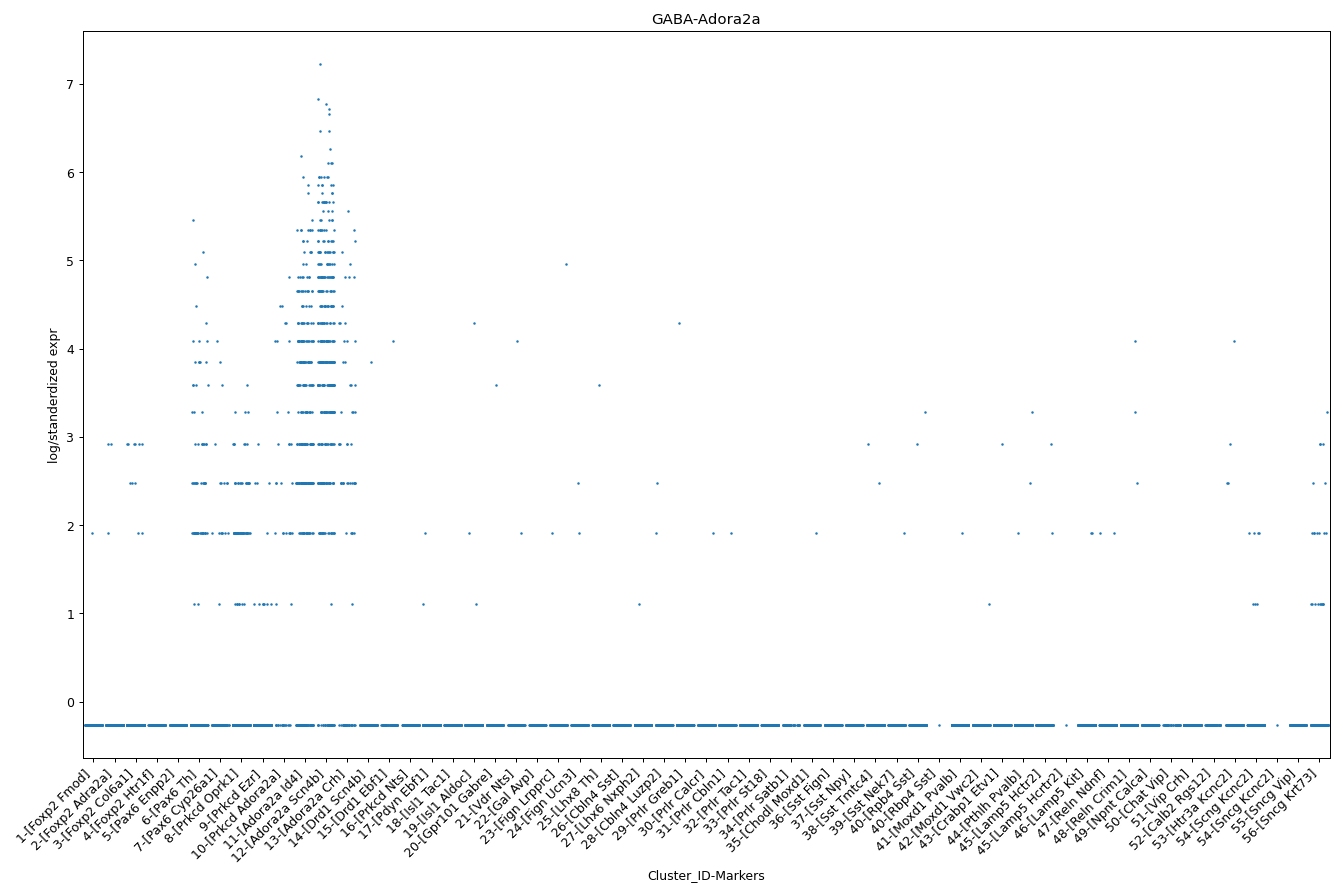

/home/isaac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/isaac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2941225/314010820.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")


In [1046]:
xticks = gene_explorer('Adora2a', 'amy', amy_df_gaba_expr_ge_cv_ls, amy_metadata_df_gaba,output_folder = '/bigdata/isaac/gaba_files/gene_explorer/',markers = True)

<IPython.core.display.Javascript object>


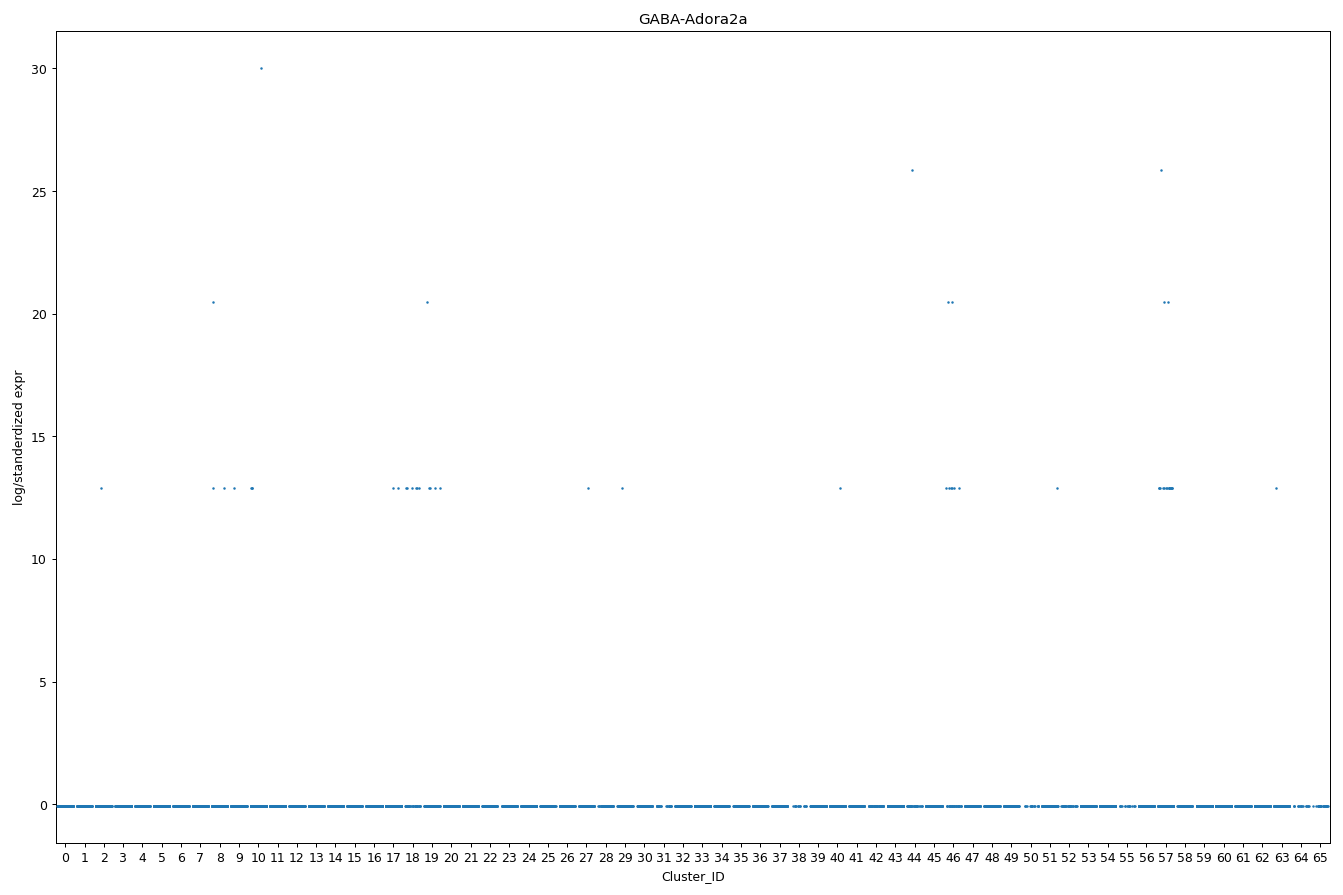

/home/isaac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/isaac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [762]:
gene_explorer('Adora2a','sd', gaba_df_prelinkage_ls, gaba_meta_data_df_prelinkage, output_folder= '/bigdata/isaac/gaba_files/gene_explorer/', markers = False)

In [785]:
sd_std = dp.compute_std_expr_per_cluster_label(gaba_df_prelinkage_ls,gaba_meta_data_df_prelinkage)

In [782]:
gaba_df_prelinkage_ls.loc[:,gaba_meta_data_df_prelinkage.loc['cluster_label']==0].std(axis=1)

Sst         7.768847e-01
Npy         1.430234e-01
Gal         1.672497e-16
Avp         1.043787e+00
Vip         1.496168e-01
                ...     
Pdlim5      5.311497e-01
Ppargc1a    1.128393e+00
Pld5        5.152531e-01
Kcnip4      1.024121e+00
Lhfp        6.629060e-01
Length: 378, dtype: float64

In [774]:
np.abs([-1,-3,-5])

array([1, 3, 5])

In [786]:
sd_std

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
Sst,0.776885,0.202036,0.180046,0.17176,0.093525,0.17008,0.19791,0.561444,0.455506,0.494832,...,0.365258,0.173379,0.157458,0.131578,1.156917,0.17759,0.883498,0.827899,0.823865,0.856126
Npy,0.143023,0.196455,0.173661,0.169205,0.249825,0.195486,0.201488,0.275809,0.227831,0.235606,...,0.354867,0.156925,0.712928,1.284656,1.085777,0.128583,1.419952,0.859638,1.369865,1.278128
Gal,0.0,0.403154,1.465221,0.124884,0.0,0.0,0.186312,0.351295,0.0,0.612514,...,0.0,0.0,0.0,0.0,0.252338,0.0,0.327853,0.0,0.0,0.0
Avp,1.043787,0.811323,0.689354,0.821005,0.626541,0.843928,0.831688,0.565005,0.912278,0.848428,...,0.602359,0.84993,0.0,0.744618,0.668681,0.629016,0.559034,0.68069,0.0,0.855279
Vip,0.149617,0.0,0.0,0.142485,0.0,0.10986,0.095362,0.165228,0.094384,0.081948,...,2.606596,1.702085,0.203893,0.215803,0.129157,0.0,0.097237,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pdlim5,0.53115,0.0,0.403188,0.161156,0.634507,0.276976,0.339419,0.370915,0.76126,0.411615,...,1.077942,1.927902,2.360427,3.011629,0.398169,0.338837,0.346068,0.42422,0.989579,0.0
Ppargc1a,1.128393,1.273338,0.706607,1.119145,0.778067,0.912663,0.789761,0.746423,0.674794,0.967174,...,0.710619,0.871343,0.759681,0.449726,1.263833,1.179106,1.026274,1.014752,0.988718,1.001407
Pld5,0.515253,0.522404,0.738841,0.315603,0.993318,1.196767,1.260979,1.109927,0.980382,0.614963,...,0.644694,0.275002,1.189795,1.435724,0.393102,0.225334,0.675174,0.56526,0.466966,0.377592
Kcnip4,1.024121,0.79913,0.74553,1.145173,0.73169,0.919887,0.937835,0.933302,0.974124,0.992664,...,0.893442,0.850294,0.162458,0.636214,0.515652,0.107085,0.510776,0.535291,1.226141,0.86319


In [780]:
np.unique(gaba_meta_data_df_prelinkage.loc['cluster_label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], dtype=object)

In [779]:
sd_avgs

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
Sst,-0.052799,-0.335815,-0.350333,-0.355693,-0.383913,-0.355985,-0.340964,-0.19556,-0.265766,-0.236357,...,-0.345609,-0.358898,-0.361009,-0.373029,0.168473,-0.35041,3.078125,-0.03385,3.957141,1.575562
Npy,-0.283375,-0.266134,-0.274041,-0.277158,-0.251861,-0.277019,-0.264008,-0.249343,-0.260414,-0.258252,...,-0.254232,-0.279362,-0.083082,0.189093,0.126427,-0.287002,3.211631,0.065238,3.251905,1.751706
Gal,-0.126186,-0.074353,0.206326,-0.121254,-0.126186,-0.126186,-0.115208,-0.086827,-0.126186,-0.037761,...,-0.126186,-0.126186,-0.126186,-0.126186,-0.105983,-0.126186,-0.091943,-0.126186,-0.126186,-0.126186
Avp,0.125462,-0.006238,-0.049596,0.012925,-0.072924,0.011349,0.023045,-0.097437,0.052388,0.03684,...,-0.093788,0.046217,-0.201913,-0.02162,-0.085422,-0.071679,-0.099653,-0.047967,-0.201913,0.04019
Vip,-0.140506,-0.154338,-0.154338,-0.141714,-0.154338,-0.146863,-0.148718,-0.143694,-0.148833,-0.150188,...,6.180234,0.292554,-0.128649,-0.138424,-0.143997,-0.154338,-0.148495,-0.154338,-0.154338,-0.154338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pdlim5,-0.11998,-0.189726,-0.149567,-0.18336,-0.089394,-0.17088,-0.161391,-0.155866,-0.056705,-0.147878,...,0.067439,0.64145,1.137411,2.250012,-0.150619,-0.161587,-0.160266,-0.145376,0.050282,-0.189726
Ppargc1a,0.235094,0.649442,-0.308002,0.18521,-0.250753,-0.095112,-0.21442,-0.241566,-0.379606,0.034571,...,-0.370182,-0.106719,-0.106876,-0.580984,1.162206,1.274981,0.27052,0.336414,0.719777,-0.197765
Pld5,-0.278213,-0.290832,-0.170091,-0.381998,0.077507,0.216949,0.506481,0.246273,0.035793,-0.234992,...,-0.230746,-0.386371,0.332568,0.861317,-0.348903,-0.39976,-0.222383,-0.267581,-0.313061,-0.352265
Kcnip4,0.348098,-0.235703,-0.318286,0.679367,-0.318462,0.103619,0.194134,0.035256,0.159885,0.24254,...,-0.105421,-0.326052,-0.788783,-0.521333,-0.664137,-0.800358,-0.669239,-0.630478,0.099243,-0.284288


In [799]:
sd_std.iloc[:,18]

Sst         0.912844
Npy         1.677503
Gal              0.0
Avp         0.879085
Vip              0.0
              ...   
Pdlim5      0.823947
Ppargc1a    0.873861
Pld5        1.162904
Kcnip4      1.063221
Lhfp        0.659029
Name: 18, Length: 378, dtype: object

In [800]:
np.array(sd_std.loc['Adora2a'])

array([9.756234245242099e-17, 9.754511229096483e-17, 0.5747838647135928,
       1.8055213276984092e-16, 9.754511229096483e-17,
       5.279659495517803e-16, 3.892544352118349e-16,
       3.3376007547841565e-16, 1.5998462458516982, 0.6560004250636323,
       1.2224706349042307, 2.3651146329460456e-16, 9.756965679380792e-17,
       5.569588103046496e-17, 4.17766800724901e-17, 8.377291221954001e-17,
       8.333847759423452e-17, 0.8714411209622085, 4.329793130180194,
       2.582252515110505, 4.179196728701715e-17, 4.179076800536723e-17,
       9.764916487990167e-17, 9.757341084458916e-17,
       2.643110496159276e-16, 9.762424357054043e-17,
       9.759740529001386e-17, 1.4959111270242904, 8.393554664213075e-17,
       1.2703393606882192, 9.759322149812297e-17, 4.239734207189668e-17,
       2.2261910680355885e-16, 0.0, 9.754511229096483e-17,
       9.768874588585031e-17, 6.96153309588041e-17, 9.744952173064797e-17,
       0.0, 3.337459435814906e-16, 0.7197205765593593, 0.0,
       8.3993

In [805]:
np.array(sd_avgs.loc['Adora2a'])

array([-0.06410437518995861, -0.06410437518995861, -0.03860246499691091,
       -0.06410437518995853, -0.06410437518995861, -0.06410437518995923,
       -0.0641043751899591, -0.06410437518995904, 0.09386529488939169,
       -0.030886502425681046, 0.00924181717544089, -0.06410437518995894,
       -0.06410437518995861, -0.06410437518995876, -0.06410437518995875,
       -0.06410437518995862, -0.06410437518995879, -0.005351675062664265,
       1.5552669220685988, 0.38810202330670357, -0.06410437518995867,
       -0.06410437518995867, -0.06410437518995861, -0.06410437518995861,
       -0.06410437518995897, -0.06410437518995861, -0.06410437518995861,
       0.10862856318428663, -0.06410437518995862, 0.06046264767608373,
       -0.06410437518995861, -0.06410437518995867, -0.06410437518995893,
       -0.0641043751899587, -0.06410437518995861, -0.06410437518995861,
       -0.06410437518995878, -0.0641043751899588, -0.0641043751899587,
       -0.06410437518995904, -0.02411989871443886, -0.064104

In [808]:
cluster_2_markers_dict

{11: ['Adora2a', 'Id4'],
 12: ['Adora2a', 'Scn4b'],
 30: ['Prlr', 'Calcr'],
 50: ['Chat', 'Vip'],
 43: ['Crabp1', 'Etv1'],
 13: ['Adora2a', 'Crh'],
 7: ['Pax6', 'Cyp26a1'],
 48: ['Reln', 'Crim1'],
 18: ['Isl1', 'Tac1'],
 15: ['Drd1', 'Ebf1'],
 14: ['Drd1', 'Scn4b'],
 19: ['Isl1', 'Aldoc'],
 55: ['Sncg', 'Vip'],
 31: ['Prlr', 'Cbln1'],
 34: ['Prlr', 'Satb1'],
 1: ['Foxp2', 'Fmod'],
 22: ['Gal', 'Avp'],
 25: ['Lhx8', 'Th'],
 20: ['Gpr101', 'Gabre'],
 42: ['Moxd1', 'Vwc2'],
 41: ['Moxd1', 'Pvalb'],
 45: ['Lamp5', 'Hcrtr2'],
 4: ['Foxp2', 'Htr1f'],
 54: ['Sncg', 'Kcnc2'],
 29: ['Prlr', 'Greb1'],
 46: ['Lamp5', 'Kit'],
 56: ['Sncg', 'Krt73'],
 27: ['Lhx6', 'Nxph2'],
 23: ['Fign', 'Lrpprc'],
 28: ['Cbln4', 'Luzp2'],
 49: ['Npnt', 'Calca'],
 8: ['Prkcd', 'Oprk1'],
 5: ['Pax6', 'Enpp2'],
 6: ['Pax6', 'Th'],
 3: ['Foxp2', 'Col6a1'],
 10: ['Prkcd', 'Adora2a'],
 9: ['Prkcd', 'Ezr'],
 16: ['Prkcd', 'Nts'],
 52: ['Calb2', 'Rgs12'],
 47: ['Reln', 'Ndnf'],
 53: ['Htr3a', 'Kcnc2'],
 40: ['Rbp4', 'Sst'

In [810]:
jitter_x = amy_metadata_df_gaba.loc['cluster_label'].astype(str).T + '-' + amy_metadata_df_gaba.loc['markers'].astype(str).T
jitter_x

GGGTATTTCTCGCGTT-1_10-1    11-['Adora2a', 'Id4']
GGTAACTAGACATCCT-1_18-1    11-['Adora2a', 'Id4']
GGTAATCGTGGACTAG-1_18-1    11-['Adora2a', 'Id4']
TTCCGGTAGTGGTGGT-1_18-1    11-['Adora2a', 'Id4']
AGGGTGAAGTACAACA-1_19-1    11-['Adora2a', 'Id4']
                                   ...          
TCGCTCAAGATTGAGT-1_76-2        51-['Vip', 'Crh']
TGCAGGCTCTTACACT-1_76-2        51-['Vip', 'Crh']
TTACAGGTCCGAGATT-1_76-2        51-['Vip', 'Crh']
TTGCGTCCAACACGAG-1_76-2        51-['Vip', 'Crh']
TTGCTGCAGCACTCCG-1_76-2        51-['Vip', 'Crh']
Length: 13006, dtype: object

<IPython.core.display.Javascript object>


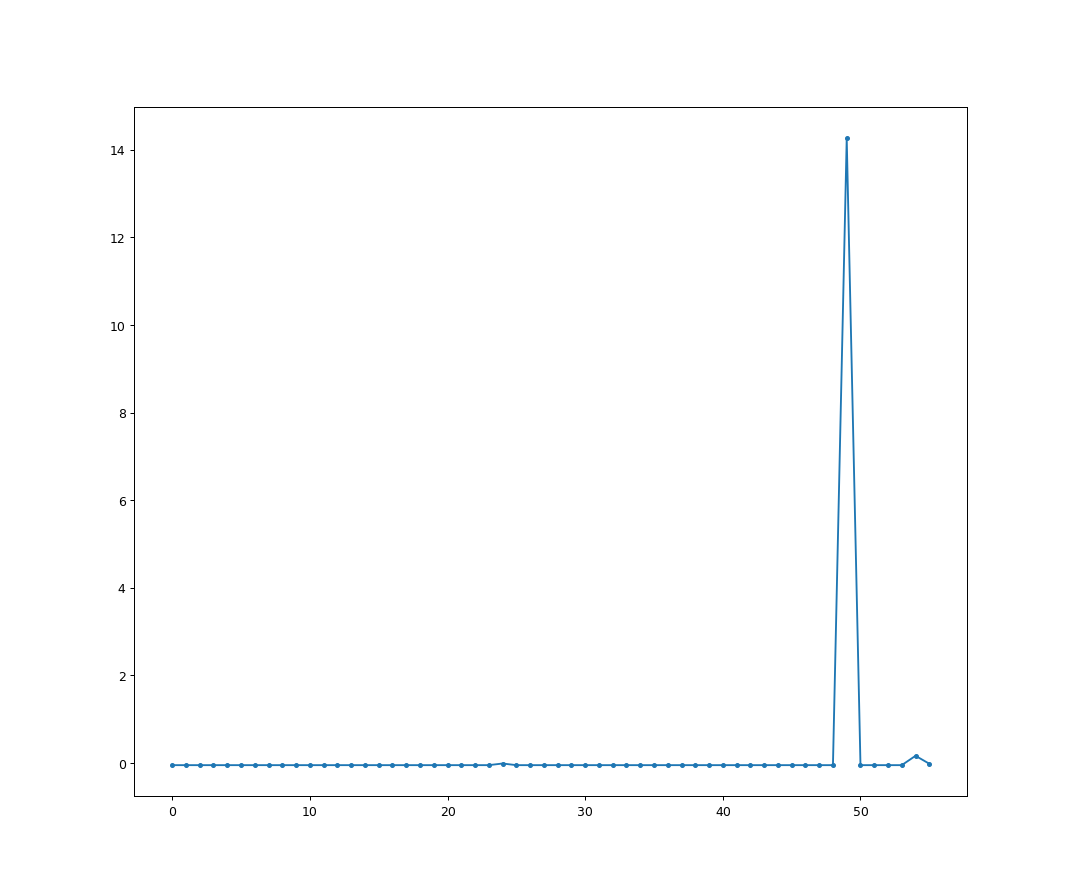

In [840]:
fig,ax = plt.subplots(figsize = (12,10))
ax.plot(np.array(amy_avgs.loc['Chat']), '.-')
#ax.set_xticklabels(xticks)
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
plt.show()

In [821]:
xticks

[Text(0, 0, '1-[Foxp2 Fmod]'),
 Text(1, 0, '2-[Foxp2 Adra2a]'),
 Text(2, 0, '3-[Foxp2 Col6a1]'),
 Text(3, 0, '4-[Foxp2 Htr1f]'),
 Text(4, 0, '5-[Pax6 Enpp2]'),
 Text(5, 0, '6-[Pax6 Th]'),
 Text(6, 0, '7-[Pax6 Cyp26a1]'),
 Text(7, 0, '8-[Prkcd Oprk1]'),
 Text(8, 0, '9-[Prkcd Ezr]'),
 Text(9, 0, '10-[Prkcd Adora2a]'),
 Text(10, 0, '11-[Adora2a Id4]'),
 Text(11, 0, '12-[Adora2a Scn4b]'),
 Text(12, 0, '13-[Adora2a Crh]'),
 Text(13, 0, '14-[Drd1 Scn4b]'),
 Text(14, 0, '15-[Drd1 Ebf1]'),
 Text(15, 0, '16-[Prkcd Nts]'),
 Text(16, 0, '17-[Pdyn Ebf1]'),
 Text(17, 0, '18-[Isl1 Tac1]'),
 Text(18, 0, '19-[Isl1 Aldoc]'),
 Text(19, 0, '20-[Gpr101 Gabre]'),
 Text(20, 0, '21-[Vdr Nts]'),
 Text(21, 0, '22-[Gal Avp]'),
 Text(22, 0, '23-[Fign Lrpprc]'),
 Text(23, 0, '24-[Fign Ucn3]'),
 Text(24, 0, '25-[Lhx8 Th]'),
 Text(25, 0, '26-[Cbln4 Sst]'),
 Text(26, 0, '27-[Lhx6 Nxph2]'),
 Text(27, 0, '28-[Cbln4 Luzp2]'),
 Text(28, 0, '29-[Prlr Greb1]'),
 Text(29, 0, '30-[Prlr Calcr]'),
 Text(30, 0, '31-[Prlr Cbln1

<IPython.core.display.Javascript object>


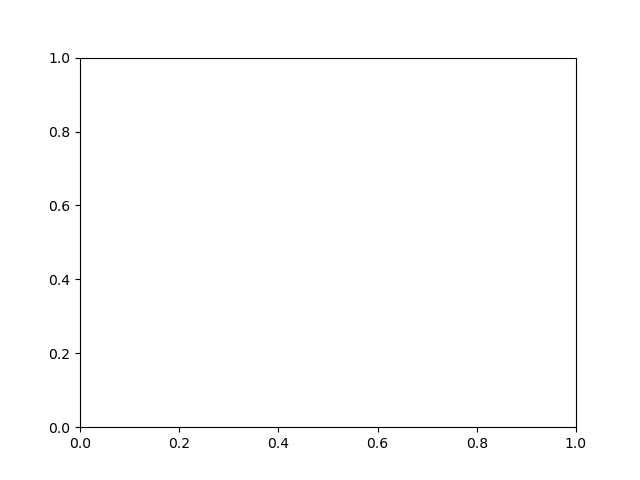

KeyError: 'Trap1a'

In [1505]:
fig,ax = plt.subplots()
ax.plot(np.array(sd_avgs.loc['Trap1a']), '.-')
plt.show()

In [1407]:
gaba_cl_mg_dict_updated['45']

['Nts']

In [1147]:
np.max(sd_avgs.loc['Chat'])

17.06952439616772

In [1506]:
'Trap1a' in sd_avgs.index

False

In [1522]:

def get_max_markers(cl_mg_dict,cluster_id):
    #sort markers for a given cluster id by max expression, return sorted gene list
    g_lst = []
    g_max_lst = []
    for g in cl_mg_dict[str(cluster_id)]:
        if g in sd_avgs.index:
            print (g)
            g_lst.append(g)
            g_max = np.max(sd_avgs.loc[g])
            g_max_lst.append(g_max)
    #print (g_max_lst)
    cluster_maxs = dict(zip(g_lst, g_max_lst))
    print (cluster_maxs)
    sorted_cluster_maxs_genes = sorted(cluster_maxs, key=cluster_maxs.get, reverse=True)
    return sorted_cluster_maxs_genes

In [1523]:
sorted_cluster_maxs_genes = get_max_markers(gaba_cl_mg_dict_updated, 31)
print ('sorted_cluster_maxs', sorted_cluster_maxs_genes)

Chat
Slc10a4
Th
Zic1
Lhx8
Pbx3
Isl1
Ngfr
Slc5a7
Slc18a3
{'Chat': 17.06952439616772, 'Slc10a4': 9.406806178159153, 'Th': 3.217474186954957, 'Zic1': 9.64654667504288, 'Lhx8': 8.521708314637577, 'Pbx3': 1.9369429408109549, 'Isl1': 4.710411893742128, 'Ngfr': 10.526251739870391, 'Slc5a7': 15.895491363747132, 'Slc18a3': 16.01087231471455}
sorted_cluster_maxs ['Chat', 'Slc18a3', 'Slc5a7', 'Ngfr', 'Zic1', 'Slc10a4', 'Lhx8', 'Isl1', 'Th', 'Pbx3']


In [1517]:
gaba_cl_mg_dict

{'31': ['Chat',
  'Slc10a4',
  'Th',
  'Zic1',
  'Lhx8',
  'Pbx3',
  'Ndrg1',
  'Isl1',
  'Trap1a',
  'Ngfr',
  'Slc5a7',
  'Slc18a3'],
 '12': ['Prok2',
  'Pdyn',
  'Map3k15',
  'Dkk2',
  'Prdm13',
  'Wfs1',
  'Rbp1',
  'Creb3l1'],
 '42': ['Arpp21', 'Cartpt', 'Pappa', 'Dkk3', 'Rcn1', 'C1ql1'],
 '43': ['Crtac1', 'Jsrp1', 'Unc13c'],
 '40': ['Rprm', 'Igfbp6'],
 '39': ['Cck', 'Bmpr1b'],
 '36': ['Prlr', 'Plagl1', 'Cbln1', 'Pde1c', 'Ppp1r17'],
 '55': ['Chst8', 'Gpd1', 'St18', 'Defb1', 'Fam159b'],
 '65': [],
 '33': [],
 '16': ['Calcr', 'Gpc3'],
 '38': ['Gm5141', 'Pgr15l'],
 '2': [],
 '20': ['Greb1'],
 '35': [],
 '0': ['Gpr101'],
 '14': ['Dnah5', 'Rxfp1', 'Lypd1'],
 '4': ['Il1rapl2', 'BC039966', 'Myh7', 'Ngb'],
 '5': ['Col23a1'],
 '3': [],
 '15': ['1700016K19Rik', 'Rmst'],
 '11': [],
 '10': [],
 '6': ['4833423E24Rik', 'Pde11a', 'Scn7a', 'Col11a1'],
 '21': ['Qrfpr', 'Npnt', 'Pax6'],
 '41': ['Calca', 'Dpf3'],
 '37': ['Angpt1', 'Dsc3'],
 '25': ['Adcyap1', 'C1ql3', 'Nrn1', 'Slc17a6'],
 '18': ['Tle

In [1511]:
if 'Trap1a' in sd_avgs.index:
    print (np.max(sd_avgs.loc['Trap1a']))

In [1086]:
with open('/bigdata/isaac/gaba_files/gaba_cl_mg_dict2024-06-07.json') as json_data:
    gaba_cl_mg_dict = json.load(json_data)

In [1096]:
gaba_df_prelinkage_ls_orig.T.shape

(559, 13529)

In [1097]:
gaba_df_prelinkage_ls.shape

(378, 13529)

In [1088]:
#create updated dict with only genes found in gaba_df_prelinkage_ls
#since gaba_df_prelinkage_ls is the gene intersected version of the _orig
gaba_cl_mg_dict_updated = dict.fromkeys(gaba_cl_mg_dict)
for k,v in gaba_cl_mg_dict.items():
    for g in v:
        #print (g)
        if str(g) not in gaba_df_prelinkage_ls.index:
            v.remove(g)
    gaba_cl_mg_dict_updated[k] = v
            

In [1471]:
gaba_cl_mg_dict_updated['9']

['Tshz2', 'Nxph2', 'Ntng1']

In [915]:
np.array(connector_df_alt_lco_marker.loc[:,'index'])

array([50, 32, 31, 34, 33, 30, 21, 28, 49, 10, 11, 12, 13, 14, 15, 17, 19,
       22, 20, 18,  6,  5,  7,  8,  9, 16, 23,  1,  4,  2,  3, 24, 29, 27,
       25, 51, 53, 52, 54, 55, 56, 47, 48, 46, 45, 44, 40, 39, 41, 43, 42,
       38, 35, 26, 36, 37])

In [1074]:
np.sort([int(x) for x in gaba_cl_mg_dict.keys()])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [1075]:
gaba_cl_mg_dict['39']

['Cck', 'Slc35d3']

In [976]:
'1' in gaba_cl_mg_dict_updated.keys()

True

In [1468]:
gaba_cl_mg_dict_updated['9']

['Tshz2', 'Nxph2', 'Ntng1']

In [1484]:
connector_df_alt_lco_marker_shared = connector_df_alt_lco_marker.copy() 

In [1485]:
connector_df_alt_lco_marker_shared.insert(5, 'sd_shared_marker', '')

In [1486]:
#1st order to get sd makers - get shared overlaps with amy data
for i in np.array(connector_df_alt_lco_marker.loc[:,'index']):
    corr_cluster = np.array(connector_df_alt_lco_marker.loc[connector_df_alt_lco.loc[:,'index']==i,'corr_cluster'])
    #print (corr_cluster[0])
    
    if str(corr_cluster[0]) in gaba_cl_mg_dict_updated.keys():
        mgs_og = gaba_cl_mg_dict_updated[str(corr_cluster[0])]
    #hack since gaba_cl_mg_dict missing a few keys. need to debug compute_marker_genes function.
    #else:
        #mgs_og = []
    #print ('og')
    #print (mgs_og)
    mgs_amy = (np.array(connector_df_alt_lco_marker.loc[connector_df_alt_lco.loc[:,'index']==i,'amy_marker'])[0])
    #print ('amy')
    #print (mgs_amy)
    shared_genes = list(set(mgs_og).intersection(mgs_amy))
    #print ('shared genes')
    #print (shared_genes)
    #add shared genes to sd_shared_marker
    connector_df_alt_lco_marker_shared.loc[connector_df_alt_lco_marker.loc[:,'index']==i,'sd_shared_marker'] = connector_df_alt_lco_marker_shared.loc[connector_df_alt_lco_marker.loc[:,'index']==i,'sd_shared_marker'].apply(lambda x: shared_genes)
    #if len(shared_genes)>1:
        #connector_df_alt_lco_marker_shared.loc[connector_df_alt_lco_marker.loc[:,'index']==i,'sd_shared_marker'] = shared_genes
    

In [1487]:
connector_df_alt_lco_marker_shared

,index,amy_marker,argmax,max,corr_cluster,sd_shared_marker
0,50,"[Chat, Vip]",0,0.887527,31,[Chat]
1,32,"[Prlr, Tac1]",3,0.873589,43,[]
2,31,"[Prlr, Cbln1]",5,0.887938,39,[]
3,34,"[Prlr, Satb1]",6,0.893623,36,[Prlr]
4,33,"[Prlr, St18]",9,0.89231,33,[]
5,30,"[Prlr, Calcr]",10,0.888857,16,[Calcr]
6,21,"[Vdr, Nts]",15,0.313583,0,[]
7,28,"[Cbln4, Luzp2]",18,0.719461,5,[]
8,49,"[Npnt, Calca]",25,0.829003,41,[Calca]
9,10,"[Prkcd, Adora2a]",28,0.344838,18,[]


In [1524]:
connector_df_alt_lco_marker_shared_top = connector_df_alt_lco_marker_shared.copy()

In [1525]:
connector_df_alt_lco_marker_shared_top.insert(6, 'sd_shared_top_marker', '')

In [1526]:
connector_df_alt_lco_marker_shared_top

,index,amy_marker,argmax,max,corr_cluster,sd_shared_marker,sd_shared_top_marker
0,50,"[Chat, Vip]",0,0.887527,31,[Chat],
1,32,"[Prlr, Tac1]",3,0.873589,43,[],
2,31,"[Prlr, Cbln1]",5,0.887938,39,[],
3,34,"[Prlr, Satb1]",6,0.893623,36,[Prlr],
4,33,"[Prlr, St18]",9,0.89231,33,[],
5,30,"[Prlr, Calcr]",10,0.888857,16,[Calcr],
6,21,"[Vdr, Nts]",15,0.313583,0,[],
7,28,"[Cbln4, Luzp2]",18,0.719461,5,[],
8,49,"[Npnt, Calca]",25,0.829003,41,[Calca],
9,10,"[Prkcd, Adora2a]",28,0.344838,18,[],


In [1530]:
gaba_cl_mg_dict_updated['31']

['Chat',
 'Slc10a4',
 'Th',
 'Zic1',
 'Lhx8',
 'Pbx3',
 'Ndrg1',
 'Isl1',
 'Trap1a',
 'Ngfr',
 'Slc5a7',
 'Slc18a3']

In [1527]:
#2nd pass - for all corr cluster with 1 sd_shared marker, get top marker from sd data cluster/marker dict. if already 2 markers, skip
current_cluster = [] #track cluster number

for i in np.array(connector_df_alt_lco_marker.loc[:,'index']):
    #get sd_shared_marker list
    l = list(connector_df_alt_lco_marker_shared.loc[connector_df_alt_lco.loc[:,'index']==i,'sd_shared_marker'])[0]
    corr_cluster = np.array(connector_df_alt_lco_marker.loc[connector_df_alt_lco.loc[:,'index']==i,'corr_cluster'])
    
    if len(l)==1:
        #get list of markers sorted by max expression
        sorted_cluster_maxs_genes = get_max_markers(gaba_cl_mg_dict_updated, corr_cluster[0])
        l_cp = l.copy()
        
        for g in sorted_cluster_maxs_genes:
            #if g not in sd_shared_marker list already, add it
            if g not in l_cp:
                l_cp.append(g)
            #break after adding
            if len(l_cp) == 2:
                break
        connector_df_alt_lco_marker_shared_top.loc[connector_df_alt_lco_marker.loc[:,'index']==i,'sd_shared_top_marker'] = connector_df_alt_lco_marker_shared_top.loc[connector_df_alt_lco_marker.loc[:,'index']==i,'sd_shared_top_marker'].apply(lambda x: l_cp)  
'''
    if len(l) == 0:
        sorted_cluster_maxs_genes = get_max_markers(gaba_cl_mg_dict_updated, corr_cluster[0])
        print (corr_cluster[0])
        print (sorted_cluster_maxs_genes[:2])
        #connector_df_alt_lco_marker_shared_top.loc[connector_df_alt_lco_marker.loc[:,'index']==i,'sd_shared_top_marker'] = connector_df_alt_lco_marker_shared_top.loc[connector_df_alt_lco_marker.loc[:,'index']==i,'sd_shared_top_marker'].apply(lambda x: sorted_cluster_maxs_genes[:2])  
'''

Chat
Slc10a4
Th
Zic1
Lhx8
Pbx3
Isl1
Ngfr
Slc5a7
Slc18a3
{'Chat': 17.06952439616772, 'Slc10a4': 9.406806178159153, 'Th': 3.217474186954957, 'Zic1': 9.64654667504288, 'Lhx8': 8.521708314637577, 'Pbx3': 1.9369429408109549, 'Isl1': 4.710411893742128, 'Ngfr': 10.526251739870391, 'Slc5a7': 15.895491363747132, 'Slc18a3': 16.01087231471455}
Prlr
Plagl1
Cbln1
Pde1c
{'Prlr': 2.0878399758946005, 'Plagl1': 2.0637661933971265, 'Cbln1': 2.765864697181022, 'Pde1c': 3.3983529458344215}
Calcr
Gpc3
{'Calcr': 2.5197939455321947, 'Gpc3': 1.2971400663397619}
Calca
{'Calca': 5.043424417233149}
Ebf1
{'Ebf1': 3.4424960613624127}
Ebf1
{'Ebf1': 3.4424960613624127}
Arhgap36
Asb4
Igsf1
Gal
{'Arhgap36': 1.83449172574227, 'Asb4': 1.6693040227108253, 'Igsf1': 1.0889554492370432, 'Gal': 3.1577577653346958}
Calb2
Cbln2
Prox1
Vip
Prox1os
Aebp1
Adra1b
Asic4
Plpp4
{'Calb2': 2.0400380333785777, 'Cbln2': 2.0765659596795105, 'Prox1': 1.663881118775187, 'Vip': 6.180234067461264, 'Prox1os': 1.838754267704054, 'Aebp1': 3.20547

"\n    if len(l) == 0:\n        sorted_cluster_maxs_genes = get_max_markers(gaba_cl_mg_dict_updated, corr_cluster[0])\n        print (corr_cluster[0])\n        print (sorted_cluster_maxs_genes[:2])\n        #connector_df_alt_lco_marker_shared_top.loc[connector_df_alt_lco_marker.loc[:,'index']==i,'sd_shared_top_marker'] = connector_df_alt_lco_marker_shared_top.loc[connector_df_alt_lco_marker.loc[:,'index']==i,'sd_shared_top_marker'].apply(lambda x: sorted_cluster_maxs_genes[:2])  \n"

In [1528]:
connector_df_alt_lco_marker_shared.head()

,index,amy_marker,argmax,max,corr_cluster,sd_shared_marker
0,50,"[Chat, Vip]",0,0.887527,31,[Chat]
1,32,"[Prlr, Tac1]",3,0.873589,43,[]
2,31,"[Prlr, Cbln1]",5,0.887938,39,[]
3,34,"[Prlr, Satb1]",6,0.893623,36,[Prlr]
4,33,"[Prlr, St18]",9,0.89231,33,[]


In [1529]:
connector_df_alt_lco_marker_shared_top

,index,amy_marker,argmax,max,corr_cluster,sd_shared_marker,sd_shared_top_marker
0,50,"[Chat, Vip]",0,0.887527,31,[Chat],"[Chat, Slc18a3]"
1,32,"[Prlr, Tac1]",3,0.873589,43,[],
2,31,"[Prlr, Cbln1]",5,0.887938,39,[],
3,34,"[Prlr, Satb1]",6,0.893623,36,[Prlr],"[Prlr, Pde1c]"
4,33,"[Prlr, St18]",9,0.89231,33,[],
5,30,"[Prlr, Calcr]",10,0.888857,16,[Calcr],"[Calcr, Gpc3]"
6,21,"[Vdr, Nts]",15,0.313583,0,[],
7,28,"[Cbln4, Luzp2]",18,0.719461,5,[],
8,49,"[Npnt, Calca]",25,0.829003,41,[Calca],[Calca]
9,10,"[Prkcd, Adora2a]",28,0.344838,18,[],


In [1462]:
gaba_cl_mg_dict['45']

['Nts']

In [1404]:
x = get_max_markers(gaba_cl_mg_dict, '32')

In [1405]:
x

['Nr4a2', 'Pou3f1', 'Megf11', 'Tacr3', 'Sema3c', 'Gpc5', 'Chrna2']

In [1043]:
np.unique(np.array(connector_df_alt_lco_marker_complete['corr_cluster']))

array([0, 5, 7, 8, 9, 16, 17, 18, 23, 24, 26, 31, 32, 33, 34, 36, 39, 41,
       43, 45, 49, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64],
      dtype=object)

In [749]:
sorted(gaba_cl_mg_dict.items(),)

[('0', ['Gpr101', 'Brinp1']),
 ('1', ['Fhit', 'Slit2', 'Cntnap5a', 'Tmem200c', 'Plk4', 'Dlk1']),
 ('10', []),
 ('11', []),
 ('12',
  ['Prok2',
   'Pdyn',
   'Esr1',
   'Map3k15',
   'Nptx2',
   'Dkk2',
   'Cd68',
   'Prdm13',
   'Wfs1',
   'Rbp1',
   'Hs3st6',
   'Creb3l1',
   'Fbn2']),
 ('13', ['RP23-231J2.1', 'C130060K24Rik', 'Zbtb20', 'Cbln4']),
 ('14', ['Nrgn', 'Dnah5', 'Rxfp1', 'Ccdc153', 'Lypd1']),
 ('15', ['Fxyd1', '1700016K19Rik', 'Plk5', 'Rmst']),
 ('16', ['Calcr', 'Myl4', 'Gpc3']),
 ('17', ['Tshz1', 'A730046J19Rik', 'Tspan9']),
 ('18', ['Tle4', 'Six3', 'Dach1', 'Cyp26b1', 'Meis2']),
 ('19', ['Npas4', 'Junb', 'Col6a1', 'Nr4a3', 'Egr4']),
 ('2', ['Col18a1']),
 ('20', ['Lamb3', 'Greb1']),
 ('21', ['Sel1l3', 'Qrfpr', 'Npnt', 'Pax6']),
 ('22',
  ['Onecut2', 'Lmo1', 'Satb2', 'Tac2', 'Syt2', 'Zfhx4', 'Pou3f2', 'Zfhx3']),
 ('23', ['Npsr1']),
 ('24', ['Arhgap36', 'H2-Q2', 'Asb4', 'Sytl4', 'Igsf1', 'Gal']),
 ('25', ['Adcyap1', 'C1ql3', 'Neurod1', 'Nrn1', 'Slc17a6', 'Lhx2']),
 ('26', ['

In [540]:
tips = sns.load_dataset("tips") 

In [541]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<IPython.core.display.Javascript object>


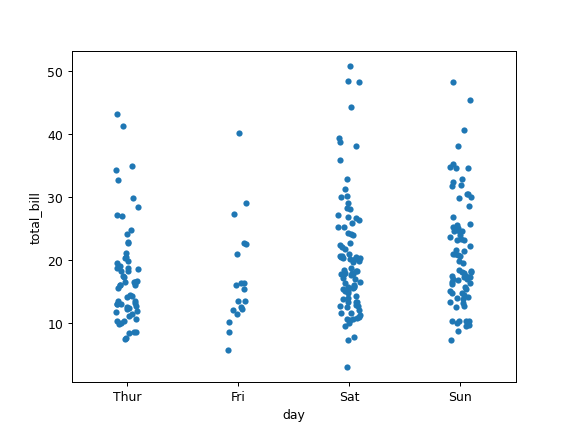

/home/isaac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/isaac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [734]:
fig,ax = plt.subplots()
sns.stripplot(x="day", y="total_bill", data=tips, jitter = 0.1)
plt.show()

In [573]:
###################old/backup/scratch###################

### corrwith() vs. corr() example

In [584]:
np.random.seed(5)
index = ["g1", "g2", "g3", "g4", "g5"]
columns = ["one", "two", "three", "four","five"]
df1 = pd.DataFrame(np.random.rand(5,5), index=index, columns=columns)
df2 = pd.DataFrame(np.random.rand(5,4), index=index, columns=columns[:4])


In [585]:
df1

,one,two,three,four,five
g1,0.221993,0.870732,0.206719,0.918611,0.488411
g2,0.611744,0.765908,0.518418,0.296801,0.187721
g3,0.080741,0.738440,0.441309,0.158310,0.879937
g4,0.274086,0.414235,0.296080,0.628788,0.579838
g5,0.599929,0.265819,0.284686,0.253588,0.327564


In [586]:
df2

,one,two,three,four
g1,0.144164,0.165613,0.963931,0.960227
g2,0.188415,0.024307,0.204556,0.699844
g3,0.779515,0.022933,0.577663,0.001642
g4,0.515473,0.639795,0.985624,0.259098
g5,0.802497,0.870483,0.922750,0.002214


In [587]:
df1.corrwith(df2, axis=0)

one     -0.122051
two     -0.942317
three   -0.946490
four     0.710635
five          NaN
dtype: float64

In [588]:
pd.concat([df1, df2],axis=1).corr()

,one,two,three,four,five,one,two,three,four
one,1.000000,-0.402054,0.212745,-0.281101,-0.924940,-0.122051,0.365828,-0.304699,0.063459
two,-0.402054,1.000000,0.257426,0.287125,0.150378,-0.658193,-0.942317,-0.450567,0.691083
three,0.212745,0.257426,1.000000,-0.726333,-0.069552,0.021379,-0.548253,-0.946490,-0.149437
four,-0.281101,0.287125,-0.726333,1.000000,-0.060772,-0.649870,0.017370,0.568173,0.710635
five,-0.924940,0.150378,-0.069552,-0.060772,1.000000,0.472897,-0.213327,0.254671,-0.429568
one,-0.122051,-0.658193,0.021379,-0.649870,0.472897,1.000000,0.488051,0.236740,-0.979477
two,0.365828,-0.942317,-0.548253,0.017370,-0.213327,0.488051,1.000000,0.672052,-0.478168
three,-0.304699,-0.450567,-0.946490,0.568173,0.254671,0.236740,0.672052,1.000000,-0.135005
four,0.063459,0.691083,-0.149437,0.710635,-0.429568,-0.979477,-0.478168,-0.135005,1.000000


In [612]:

# Initialize an empty dataframe to hold the correlation coefficients
correlation_matrix_chat = pd.DataFrame(index=df1.columns, columns=df2.columns)

# Compute the correlation coefficients
for col1 in df1.columns:
    for col2 in df2.columns:
        correlation_matrix_chat.loc[col1, col2] = df1[col1].corr(df2[col2])

In [613]:
correlation_matrix_chat

,one,two,three,four
one,-0.122051,0.365828,-0.304699,0.063459
two,-0.658193,-0.942317,-0.450567,0.691083
three,0.021379,-0.548253,-0.94649,-0.149437
four,-0.64987,0.01737,0.568173,0.710635
five,0.472897,-0.213327,0.254671,-0.429568


In [472]:
np.random.rand(4,4)

array([[0.64974906, 0.24880237, 0.36565569, 0.47207162],
       [0.25539014, 0.61145039, 0.42194013, 0.89595233],
       [0.67309502, 0.01799882, 0.57259172, 0.51005648],
       [0.26610062, 0.63002322, 0.90600956, 0.26364928]])

In [956]:
sd_avgs.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65],
      dtype='object')

2024-06-07 gaba_cl_mg_dict is missing a few clusters for some reason, reran on 2024-06-27

In [315]:

#with open('/bigdata/isaac/gaba_files/gaba_cl_mg_dict2024-06-07.json') as json_data:
    #gaba_cl_mg_dict = json.load(json_data)

In [317]:
sorted(gaba_cl_mg_dict.items())

[('0', ['Gpr101', 'Brinp1']),
 ('1', ['Fhit', 'Slit2', 'Cntnap5a', 'Tmem200c', 'Plk4', 'Dlk1']),
 ('10', []),
 ('11', []),
 ('12',
  ['Prok2',
   'Pdyn',
   'Esr1',
   'Map3k15',
   'Nptx2',
   'Dkk2',
   'Cd68',
   'Prdm13',
   'Wfs1',
   'Rbp1',
   'Hs3st6',
   'Creb3l1',
   'Fbn2']),
 ('13', ['RP23-231J2.1', 'C130060K24Rik', 'Zbtb20', 'Cbln4']),
 ('14', ['Nrgn', 'Dnah5', 'Rxfp1', 'Ccdc153', 'Lypd1']),
 ('15', ['Fxyd1', '1700016K19Rik', 'Plk5', 'Rmst']),
 ('16', ['Calcr', 'Myl4', 'Gpc3']),
 ('17', ['Tshz1', 'A730046J19Rik', 'Tspan9']),
 ('18', ['Tle4', 'Six3', 'Dach1', 'Cyp26b1', 'Meis2']),
 ('19', ['Npas4', 'Junb', 'Col6a1', 'Nr4a3', 'Egr4']),
 ('2', ['Col18a1']),
 ('20', ['Lamb3', 'Greb1']),
 ('21', ['Sel1l3', 'Qrfpr', 'Npnt', 'Pax6']),
 ('22',
  ['Onecut2', 'Lmo1', 'Satb2', 'Tac2', 'Syt2', 'Zfhx4', 'Pou3f2', 'Zfhx3']),
 ('23', ['Npsr1']),
 ('24', ['Arhgap36', 'H2-Q2', 'Asb4', 'Sytl4', 'Igsf1', 'Gal']),
 ('25', ['Adcyap1', 'C1ql3', 'Neurod1', 'Nrn1', 'Slc17a6', 'Lhx2']),
 ('26', ['

In [61]:
gaba_cl_mg_dict['31']

['Chat',
 'Matn2',
 'Slc10a4',
 'Th',
 'Zic1',
 'Hspb8',
 'Lhx8',
 'Nkx2-1',
 'Pbx3',
 'Deptor',
 'Ndrg1',
 'Isl1',
 'Ntrk1',
 'Trap1a',
 'Ngfr',
 'Slc5a7',
 'Slc18a3']

In [40]:
gaba_df_marker_log_and_std.index[:18]

Index(['Chat', 'Matn2', 'Slc10a4', 'Th', 'Zic1', 'Hspb8', 'Lhx8', 'Nkx2-1',
       'Pbx3', 'Deptor', 'Ndrg1', 'Isl1', 'Ntrk1', 'Trap1a', 'Ngfr', 'Slc5a7',
       'Slc18a3', 'Prok2'],
      dtype='object', name='gene')

In [47]:
gaba_df_marker_log_and_std.shape

(324, 13529)

In [50]:
gaba_df_marker

,GCAGCTGTCCCGTTGT-1_10X52_1,GGGTCACGTGCCGTTG-1_10X36_1,CCGCAAGGTGTTATCG-1_10X36_1,ACTACGAGTCCACTCT-1_10X37_1,AAGATAGGTAACACCT-1_10X37_2,GATGAGGGTATAATGG-1_10X52_2,CAACAACAGACATATG-1_10X35_2,GATAGCTGTAACGCGA-1_10X36_2,ACACCAATCTACCCAC-1_10X52_2,GCAACATAGATCGACG-1_10X51_2,...,ACTACGAAGCGATGAC-1_10X35_1,GGCACGTAGAGAGCAA-1_10X36_1,ATTACTCAGGTGAGAA-1_10X38_1,CATCGGGGTGTTCCTC-1_10X38_1,GAGGCCTAGCGTATGG-1_10X37_1,TCCACGTCATCCTTGC-1_10X36_1,TAGGTACTCACGGGAA-1_10X35_2,TAACCAGGTACAGGTG-1_10X51_1,CAAGAGGTCCTACAAG-1_10X35_2,TTCCGGTAGATAACGT-1_10X51_4
gene,,,,,,,,,,,,,,,,,,,,,
Chat,1,0,25,0,10,0,6,0,4,0,...,0,0,0,0,0,0,0,0,0,0
Matn2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Slc10a4,0,6,49,0,33,1,7,0,5,2,...,0,0,0,0,0,0,0,0,0,0
Th,0,0,2,0,0,0,0,0,7,0,...,0,0,0,0,0,0,0,0,0,0
Zic1,9,2,46,0,15,0,5,6,4,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ccdc109b,0,0,1,0,2,1,0,0,1,0,...,0,0,0,1,2,0,0,0,1,0
Npy,0,0,0,0,0,0,0,0,0,0,...,13,4,7,32,230,217,79,141,229,91
Gcnt1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2,3,0,3,0,0


In [167]:
gaba_meta_data_df_plis

,GCAGCTGTCCCGTTGT-1_10X52_1,GGGTCACGTGCCGTTG-1_10X36_1,CCGCAAGGTGTTATCG-1_10X36_1,ACTACGAGTCCACTCT-1_10X37_1,AAGATAGGTAACACCT-1_10X37_2,GATGAGGGTATAATGG-1_10X52_2,CAACAACAGACATATG-1_10X35_2,GATAGCTGTAACGCGA-1_10X36_2,ACACCAATCTACCCAC-1_10X52_2,GCAACATAGATCGACG-1_10X51_2,...,ACTACGAAGCGATGAC-1_10X35_1,GGCACGTAGAGAGCAA-1_10X36_1,ATTACTCAGGTGAGAA-1_10X38_1,CATCGGGGTGTTCCTC-1_10X38_1,GAGGCCTAGCGTATGG-1_10X37_1,TCCACGTCATCCTTGC-1_10X36_1,TAGGTACTCACGGGAA-1_10X35_2,TAACCAGGTACAGGTG-1_10X51_1,CAAGAGGTCCTACAAG-1_10X35_2,TTCCGGTAGATAACGT-1_10X51_4
Serial_Number,101.0,65.0,65.0,67.0,68.0,102.0,64.0,66.0,102.0,98.0,...,63.0,65.0,69.0,69.0,67.0,65.0,64.0,97.0,64.0,100.0
Date_Captured,05/31/20,2019-11-24,2019-11-24,2019-11-25,2019-11-25,05/31/20,2019-11-20,2019-11-24,05/31/20,05/31/20,...,2019-11-20,2019-11-24,2019-12-01,2019-12-01,2019-11-25,2019-11-24,2019-11-20,05/31/20,2019-11-20,05/31/20
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,C57Bl/6,,,,,C57Bl/6,,,C57Bl/6,C57Bl/6,...,,,,,,,,C57Bl/6,,C57Bl/6
Project,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,...,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph
Group,Breeder-F,Naïve-M,Naïve-M,Naïve-M,Naïve-M,Breeder-F,Naïve-F,Naïve-M,Breeder-F,Breeder-F,...,Naïve-F,Naïve-M,Naïve-F,Naïve-F,Naïve-M,Naïve-M,Naïve-F,Breeder-F,Naïve-F,Breeder-M
ChipID,10X52,10X36,10X36,10X37,10X37,10X52,10X35,10X36,10X52,10X51,...,10X35,10X36,10X38,10X38,10X37,10X36,10X35,10X51,10X35,10X51
SampleID,10X52_1,10X36_1,10X36_1,10X37_1,10X37_2,10X52_2,10X35_2,10X36_2,10X52_2,10X51_2,...,10X35_1,10X36_1,10X38_1,10X38_1,10X37_1,10X36_1,10X35_2,10X51_1,10X35_2,10X51_4
DonorID,DI-B3-F,DI3,DI3,"DI4,DI5","DI4,DI5",DI-B3-F,"DI1,DI2",DI3,DI-B3-F,DI-B1-F,...,"DI1,DI2",DI3,DI6,DI6,"DI4,DI5",DI3,"DI1,DI2",DI-B1-F,"DI1,DI2",DI-B1-M


In [93]:
gaba_mean_marker_per_cluster = pd.DataFrame(columns=['gene', 'avg_expr','cluster_id'])
for k,v in gaba_cl_mg_dict.items():
    #print (k,v)
    tmp_df = pd.DataFrame({'gene':gaba_cl_mg_dict[k],
                           'avg_expr':np.array(gaba_df_marker.loc[gaba_cl_mg_dict[k],gaba_df_marker.iloc[:,np.where(gaba_meta_data_df_plis.loc['cluster_label']==int(k))[0]].columns].mean(axis=1)), 
                           'cluster_id':np.array(int(k)*np.ones(len(gaba_cl_mg_dict[k])))})
    gaba_mean_marker_per_cluster = pd.concat([gaba_mean_marker_per_cluster, tmp_df])

gaba_mean_marker_per_cluster

/tmp/ipykernel_2445590/3401018307.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaba_mean_marker_per_cluster = pd.concat([gaba_mean_marker_per_cluster, tmp_df])


,gene,avg_expr,cluster_id
0,Chat,4.142857,31.0
1,Matn2,0.250000,31.0
2,Slc10a4,8.357143,31.0
3,Th,1.607143,31.0
4,Zic1,6.964286,31.0
...,...,...,...
2,Mpped1,3.461957,63.0
3,Tmem132c,1.076087,63.0
4,Gpr83,3.277174,63.0
5,Moxd1,3.320652,63.0


In [59]:
np.where(gaba_meta_data_df_plis.loc['cluster_label']==31)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [98]:
gaba_cl_mg_dict['63']

['Efcab6', '3110035E14Rik', 'Mpped1', 'Tmem132c', 'Gpr83', 'Moxd1']

In [112]:
def compute_class_marker_mean(df,meta_data_df,cl_mg_dict):
    '''
    For level 2 analysis. Computes average expression of each marker gene for a specific cell class (e.g. gaba)                  
    ----------------------------------------------------------------------
    Parameters

    df: pandas.core.frame.DataFrame
        marker gene expression dataframe of a single cell class
    meta_data_df: pandas.core.frame.DataFrame
        gene expression metadata corresponding to df
    cl_mg_dict: pandas.core.frame.DataFrame
        2D input array, typically output from tsne, in dataframe format
    ----------------------------------------------------------------------
    Returns
    mean_marker_per_cluster: pandas.core.frame.DataFrame
        dataframe storing marker gene, avg expression, and cluster ID
    '''
    mean_marker_per_cluster = pd.DataFrame(columns=['gene', 'avg_expr','cluster_id'])
    for k,v in cl_mg_dict.items():
        #print (k,v)
        tmp_df = pd.DataFrame({'gene':cl_mg_dict[k],
                               'avg_expr':np.array(df.loc[cl_mg_dict[k],df.iloc[:,np.where(meta_data_df.loc['cluster_label']==int(k))[0]].columns].mean(axis=1)), 
                               'cluster_id':np.array(int(k)*np.ones(len(cl_mg_dict[k])))})
        
        #print (tmp_df.head())
        mean_marker_per_cluster = pd.concat([mean_marker_per_cluster, tmp_df])

    return mean_marker_per_cluster 

In [113]:
gaba_mean_marker_per_cluster = compute_class_marker_mean(gaba_df_marker, gaba_meta_data_df_plis, gaba_cl_mg_dict)

/tmp/ipykernel_2445590/2024660757.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mean_marker_per_cluster = pd.concat([mean_marker_per_cluster, tmp_df])


In [114]:
gaba_mean_marker_per_cluster

,gene,avg_expr,cluster_id
0,Chat,4.142857,31.0
1,Matn2,0.250000,31.0
2,Slc10a4,8.357143,31.0
3,Th,1.607143,31.0
4,Zic1,6.964286,31.0
...,...,...,...
2,Mpped1,3.461957,63.0
3,Tmem132c,1.076087,63.0
4,Gpr83,3.277174,63.0
5,Moxd1,3.320652,63.0
